# Purpose of the Notebook

# Problem Statement

# Module Import

In [1]:
import os
#uncomment this if you want to run on your CPU instead of GPU
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
#os.environ["CUDA_VISIBLE_DEVICES"] = ""
import datetime
from collections import Counter
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re

#to speed up pandas operands
from pandarallel import pandarallel

import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_score, classification_report
from sklearn.metrics import confusion_matrix

import nltk
from nltk.corpus import wordnet
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, GRU
from tensorflow.keras.layers import Dense, Dropout, Bidirectional
from tensorflow.keras.layers import GlobalAveragePooling1D, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, GlobalMaxPooling1D

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model

import tensorflow.keras.utils as ku 

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN


import emoji

from project5_utils import my_print
from project5_utils import my_wait

from MyMovieReview import MovieReview
from MyMovieReview import MovieReviewGenerator

from mymovie import Movie

In [2]:
print("tensorflow version is {}".format(tensorflow.__version__))
print("keras version is {}".format(keras.__version__))


tensorflow version is 2.2.0
keras version is 2.3.0-tf


In [3]:
%matplotlib inline 

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/magreen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
LOG_FILE = open("../Data/notebook.log","w")
DEBUG = 1

In [6]:
#Setting these for now will adjust them
VOCAB_SIZE = 400000
BASELINE_EMBEDDING_DIM = 32
GLOVE_EMBEDDING_DIM = 100
#will calc this based on training set
#MAX_LENGTH = 1000
TRUC_TYPE = "post"
PAD_TYPE = "post"
#Out of Value Token -- or token to indicate a 
OOV_TOK = "<OOV>"

TRAIN_SET_PERCENT =  90.0
EPOCHS = 100
RANDOM_STATE = 42

BATCH_SIZE = 96

# Data Processing
Get reviews from PKL files into format that can be tokenized

In [7]:
MOVIE_REVIEWS_PKL_FILE = open("../Data/Reviews_back14.pkl","rb")

list_of_movie_reviews = []

while 1:
    try:
        temp_review = pickle.load(MOVIE_REVIEWS_PKL_FILE)
        list_of_movie_reviews.append(temp_review)
        my_print("added this review to the list ==>\n{}\n".format(temp_review), DEBUG, LOG_FILE)
    except EOFError:
        my_print("DONE reading movie reviews", DEBUG, LOG_FILE)
        break
        
MOVIE_REVIEWS_PKL_FILE.close()
print("Number of movie reviews read: {}".format(len(list_of_movie_reviews)))

Number of movie reviews read: 62718


In [8]:
col_names = list(list_of_movie_reviews[0].__dict__.keys())
#col_values = list(list_of_movie_reviews[0].__dict__.values()) --> TODO: REMOVE

In [9]:
list_of_movie_review_lists = []

for review_col_name in col_names:
    list_of_movie_review_data_vals = []
    
    for review_obj in list_of_movie_reviews:
        list_of_movie_review_data_vals.append ( review_obj.__dict__[review_col_name] )
        
    list_of_movie_review_lists.append(list_of_movie_review_data_vals)
    
reviews_dict = dict(zip(col_names,list_of_movie_review_lists))
reviews_df = pd.DataFrame(reviews_dict)
reviews_df.head()

,review_text,review_star_rating,reviewer_name,directlink_url,reviewlink_url,title,review_title,review_date
0,At the end of this movie there's a shot of the...,2,veardleyw,http://www.imdb.com/title/tt4669788/,http://www.imdb.com/review/rw4675276/,On the Basis of Sex,"Feeble, telemovie-style travesty of a potentia...",20 February 2019
1,The film starts in 1956 with RBG (Felicity Jon...,8,nogodnomasters,http://www.imdb.com/title/tt4669788/,http://www.imdb.com/review/rw4783407/,On the Basis of Sex,It's not a movement if everyone is just sitting.,15 April 2019
2,This well meaning movie shows the discriminati...,5,phd_travel,http://www.imdb.com/title/tt4669788/,http://www.imdb.com/review/rw4590175/,On the Basis of Sex,Well intentioned but miscast,18 January 2019
3,Why would you make a movie about the second fe...,1,Viking131313,http://www.imdb.com/title/tt4669788/,http://www.imdb.com/review/rw4621289/,On the Basis of Sex,Makes no sense.,2 February 2019
4,This movie was very well done. Good acting and...,10,MikeChm,http://www.imdb.com/title/tt4669788/,http://www.imdb.com/review/rw4583636/,On the Basis of Sex,Well worth going to see!,15 January 2019


**CLEANING**



In [10]:
#Get rid of instances of people spamming the same review
reviews_df.drop_duplicates(subset=["review_text"],keep="first",inplace=True)

In [11]:
#Get rid of reviews where "review_star_rating" is missing or "review_text" is missing
mask = (reviews_df["review_text"] == "EMPTY") | (reviews_df["review_star_rating"] == -1)
mask_keep = ~mask

In [12]:
reviews_df = reviews_df[mask_keep]

In [13]:
reviews_df.dropna(inplace=True)

In [14]:
reviews_df.shape

(62612, 8)

In [15]:
text_of_reviews = reviews_df[["review_title","review_text","review_star_rating"]]

Text corpus will be composed of the review title concatenated with the review text

In [16]:
text_of_reviews["review_observation"] = text_of_reviews["review_title"] + " " + text_of_reviews["review_text"]

<ipython-input-16-b4d769d80be9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_of_reviews["review_observation"] = text_of_reviews["review_title"] + " " + text_of_reviews["review_text"]


In [17]:
text_of_reviews = text_of_reviews.rename(columns={"review_text":"review_text_original"})

In [18]:
text_of_reviews = text_of_reviews.rename(columns= {"review_observation":"review_text"})

In [19]:
text_of_reviews.head()

,review_title,review_text_original,review_star_rating,review_text
0,"Feeble, telemovie-style travesty of a potentia...",At the end of this movie there's a shot of the...,2,"Feeble, telemovie-style travesty of a potentia..."
1,It's not a movement if everyone is just sitting.,The film starts in 1956 with RBG (Felicity Jon...,8,It's not a movement if everyone is just sittin...
2,Well intentioned but miscast,This well meaning movie shows the discriminati...,5,Well intentioned but miscast This well meaning...
3,Makes no sense.,Why would you make a movie about the second fe...,1,Makes no sense. Why would you make a movie abo...
4,Well worth going to see!,This movie was very well done. Good acting and...,10,Well worth going to see! This movie was very w...


**Some Statistics**
* Are the classes balanced?
* What's the mean, mode, stddev of the classes?
* Length of reviews: mean, mode, std dev, and all of this for each class

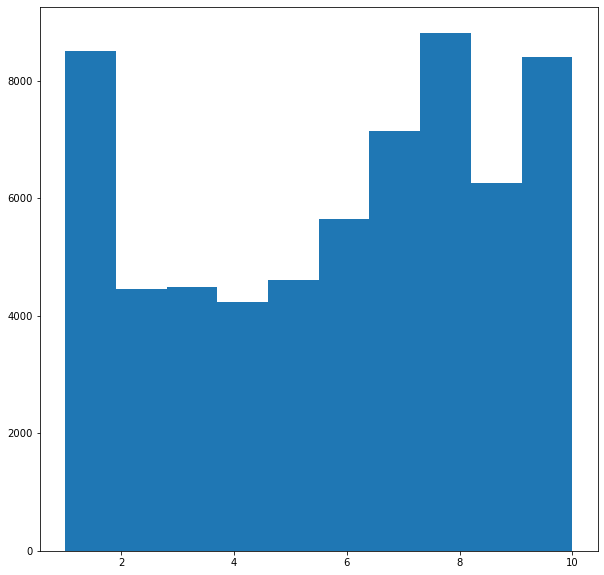

In [20]:
plt.figure(figsize=(10,10))
plt.hist(text_of_reviews["review_star_rating"],10);

In [21]:
text_of_reviews.describe()

,review_star_rating
count,62612.000000
mean,5.844055
std,3.038270
min,1.000000
25%,3.000000
50%,6.000000
75%,8.000000
max,10.000000


In [22]:
text_of_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62612 entries, 0 to 62717
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   review_title          62612 non-null  object
 1   review_text_original  62612 non-null  object
 2   review_star_rating    62612 non-null  int64 
 3   review_text           62612 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.4+ MB


In [23]:
len(text_of_reviews)

62612

In [24]:
median = text_of_reviews["review_star_rating"].median()
mode = text_of_reviews["review_star_rating"].mode()

print("median = ", median)
print("mode = ", mode)

#mode = text_of_reviews["review_star_rating"].mode(axis=1)

median =  6.0
mode =  0    8
dtype: int64


In [25]:
text_of_reviews["review_star_rating"].value_counts()

8     8816
1     8513
10    8407
7     7155
9     6264
6     5652
5     4618
3     4492
2     4461
4     4234
Name: review_star_rating, dtype: int64

Just some thoughts: I have alot of very good and very bad reviews. Not a lot of 2,3,4,5,6's. I'm worried the precision of the model is going to suffer and it will just be a binary classifier.
🙁

## Cleaning and Lemmatization
To reduce dimentionality of the corpus


In [26]:
def remove_html_punct(row):
    """This function removes HTML and punctuation and anything that is or contains a number from the Text"""
    
    NLTK_WORDS = set(nltk.corpus.words.words())
    
    text_to_process = row["review_text"]
    text_to_process = text_to_process.lower()
    text_to_process = re.sub("<.*?>","",text_to_process)
    text_to_process = re.sub("[\.|\!|\?|\,|\;|\:|\&|\(|\)|\-|\%|_|\#|\$|\*|\+|\/|\=|\[|\]|\^|\`|\{|\}|\~]","",text_to_process)
    text_to_process = re.sub("\w*\d+\w*","",text_to_process)
    text_to_process_list = text_to_process.split()
    text_to_process_list = [review_word for review_word in text_to_process_list if review_word in NLTK_WORDS]
    text_to_process = " ".join(text_to_process_list)
    return text_to_process

In [27]:
pandarallel.initialize()
start_time = datetime.datetime.now()

text_of_reviews["review_text"] = text_of_reviews.parallel_apply(remove_html_punct, axis=1)

end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))

INFO: Pandarallel will run on 64 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
time spent doing operation is 0:11:44.013514


In [28]:
text_of_reviews["review_text"] = text_of_reviews["review_text"].apply(lambda x : x.lower())

In [29]:
def tokenize_text(row):
    temp_tokenized_txt = word_tokenize(row["review_text"])
    return temp_tokenized_txt


In [30]:
pandarallel.initialize()
start_time = datetime.datetime.now()

text_of_reviews["review_text"] = text_of_reviews.parallel_apply(tokenize_text,axis=1)

end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))

INFO: Pandarallel will run on 64 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
time spent doing operation is 0:00:04.661597


In [31]:
wordNetLemmatizer = WordNetLemmatizer()

In [32]:
def calc_partofspeech(raw_pos):
    """translates from POS generated by pos_tag() to a POS encoding that WordNetLemmatizer.lemmatize() understands"""
    #print("word = ",word)
    #[(output_word, output_pos)] = pos_tag(word_tokenize(word))
    
    #decode output_pos to the pos required by the lemmatizer
    
    if "JJ" in raw_pos:
        pos = "a"
    elif "RB" in raw_pos:
        pos = "r"
    elif "VB" in raw_pos:
        pos = "v"
    else:
        pos = "n"
    
    return pos

In [33]:
def lemmatize_it(row):
    
    pos_result = pos_tag(row["review_text"])
    
    temp_mydoc_lemmatized = []
    
    for myword,myPOS in pos_result:
        temp_word_lemmatized = wordNetLemmatizer.lemmatize(myword,calc_partofspeech(myPOS))
        temp_mydoc_lemmatized.append(temp_word_lemmatized)
    
    return temp_mydoc_lemmatized
        


In [34]:
pandarallel.initialize()
start_time = datetime.datetime.now()

text_of_reviews["review_text"] = text_of_reviews.parallel_apply(lemmatize_it,axis=1)

end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))

INFO: Pandarallel will run on 64 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
time spent doing operation is 0:00:44.005681


In [35]:
pandarallel.initialize()
start_time = datetime.datetime.now()
text_of_reviews["review_text"]  = text_of_reviews.parallel_apply(lambda x : " ".join(x["review_text"]), axis=1)
end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))

INFO: Pandarallel will run on 64 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
time spent doing operation is 0:00:04.433417


## Stop word removal
Should I do it?

It lowers dimensionality which can improve training time.

But for a sequence model won't removing the stop words hurt the ability of the model to learn sequences that may be indicative of a specific class? In this project I need pretty high precision because I have 10 categories to classify based on text.

Some stuff I've read:

**Pro or Con**:

* https://stackoverflow.com/questions/37325914/should-i-remove-stopwords-when-feed-sentence-to-rnn
* https://www.quora.com/Is-text-preprocessing-e-g-stop-words-removing-still-necessary-in-neural-based-NLP
* https://www.quora.com/Is-text-preprocessing-e-g-stop-words-removing-still-necessary-in-neural-based-NLP

Reading the last link I think I should keep the stop words. The star rating applied to a reviews is a form of sentiment about the review. If a reviewer says "I was not happy with the ending of the movie," stop word removal may convert that to "happy movie ending". This may result in two reviews containing the words "happy movie ending": One with a review of 2 and another with a review of 8 with the original text for the latter score being "I was happy with the ending of the movie."

So will not do stop word removal for now but will keep in as an option if results seem to call for it.


## Converting Star Rating To Net Promoter Score
See https://www.netpromoter.com/know/ for more details

In [37]:
#shifting range of ratings from 1,10 to 0,9
text_of_reviews["review_star_rating"] = text_of_reviews["review_star_rating"] - 1

In [108]:
def gen_net_promoter(row):
    if row["review_star_rating"] <= 6:
        #Detractor
        return 0
    elif row["review_star_rating"] <= 8:
        #Passive
        return 1
    else:
        ##Promotor
        return 2

In [109]:
pandarallel.initialize()
start_time = datetime.datetime.now()

text_of_reviews["net_promoter_score"] = text_of_reviews.parallel_apply(gen_net_promoter,axis=1)

end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))

INFO: Pandarallel will run on 64 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
time spent doing operation is 0:00:07.594939


In [110]:
text_of_reviews.shape

(62612, 5)

In [154]:
text_of_reviews["net_promoter_score"].value_counts()

0    31970
1    22235
2     8407
Name: net_promoter_score, dtype: int64

In [111]:
text_of_reviews.head()

,review_title,review_text_original,review_star_rating,review_text,net_promoter_score
57473,One of very few movies that would be better if...,"I think it would be, at least...The movie is p...",6,one of very few that would be good if it be lo...,1
57898,Bullying,Val I don't like the clothes you wear did your...,5,bully i like the clothes you wear do your say ...,0
9096,Chalamet and Carell stand out in an emotional ...,Timothee Chalamet gives an outstanding perform...,6,and stand out in an emotional roller coaster a...,1
12540,"""...You hurt me, I hurt you worse""",Kevin Costner is a Criminal that happens to ha...,9,hurt me i hurt you be a criminal that to have ...,2
2618,"Had amazing potential, makes absolutely no sense","First, I enjoyed some parts of this film. The ...",2,have amazing potential absolutely no sense fir...,0


## Train Test Split
Did it this way to preserve incides. I could have did it on the original data frame (TODO).

In [113]:
#Randomizing and doing train test split but preserving indices
train_set_size = int ( ( text_of_reviews.shape[0] * TRAIN_SET_PERCENT ) / 100 )
#test_set_size =  text_of_reviews.shape[0] - train_set_size

review_indices = np.arange(text_of_reviews.shape[0]) 

np.random.seed(RANDOM_STATE)
np.random.shuffle( review_indices)


text_of_reviews = text_of_reviews.iloc[review_indices]

training_indices = review_indices[:train_set_size]
testing_indices = review_indices[train_set_size:]


print(train_set_size)
print(text_of_reviews.shape)
print(training_indices.shape)
print(testing_indices.shape)


56350
(62612, 5)
(56350,)
(6262,)


In [114]:
testing_indices[:3]

array([25613, 14232, 24229])

In [115]:
text_of_reviews_np  = np.array(text_of_reviews)

text_test_set = text_of_reviews_np[testing_indices]
text_train_set = text_of_reviews_np[training_indices]
text_test_set.shape, text_train_set.shape

((6262, 5), (56350, 5))

In [116]:
text_test_set[:1]

array([['The poetry of people and places',
        "Paterson is a celebration of the small details in life. A poetic and charming love-story about a perfectly ordinary couple, living in a perfectly ordinary town. The town in question is Paterson, New Jersey. Home of poet William Carlos Williams, comedian Lou Costello, and one of America's largest waterfalls. The man in question, in true Jarmusch style, is also named Paterson (played with pinpoint subtly by Adam Driver). Paterson is a hard-working bus driver who quietly goes about his duties, all the while allowing the scenery and eavesdropped conversation to inspire his main passion in life; writing poetry. Meanwhile, his girlfriend and the love of his life, played without fault by Iranian actress Golshifteh Farahani, is a stay-at-home creative. She spends her day baking imaginative cupcakes and making new curtains from scratch. The films narrative centres around a seven day week. Each day brings a new variation on the theme, and each 

In [117]:
print(text_of_reviews.loc[23136,"review_text"])

every minute of this maybe this movie be just not for everyone but especially towards i think every girl who have a broken heart and to watch a fun movie that very true to life will really enjoy this movie i do


In [118]:
text_of_reviews.head()

,review_title,review_text_original,review_star_rating,review_text,net_promoter_score
56673,Hot Mess,It is tragically unfortunate that the casting ...,2,hot mess it be tragically unfortunate that the...,0
25453,"Critics will hate it, but it is better than most","It is an Action pic, so good action, fun one-l...",8,will hate it but it be well than most it be an...,1
43394,Implausible and charming,Don't look too deeply. This is a movie that wa...,6,implausible and charming look too deeply this ...,1
58929,Save yourself the agony,"Absolutely terrible, the acting is lazy, it's ...",0,save yourself the agony absolutely terrible th...,0
21200,Hilarious,I thought this was out right hilarious and a r...,7,hilarious i think this be out right hilarious ...,1


In [119]:
#spent hours trying to re-implement train_test_split() :*-(

#train_new_reviews = text_of_reviews.loc[text_of_reviews.index.intersection(training_indices),"review_text"]
#train_new_reviews_rating = text_of_reviews.loc[text_of_reviews.index.intersection(training_indices),"review_star_rating"]

#train_text_reviews = text_of_reviews.sample(n=train_set_size, random_state=RANDOM_STATE, )

#test_new_reviews = text_of_reviews.loc[text_of_reviews.index.intersection(testing_indices),"review_text"]
#test_new_reviews_rating = text_of_reviews.loc[text_of_reviews.index.intersection(testing_indices),"review_star_rating"]

#X = text_of_reviews["review_text"]
#y = text_of_reviews["review_star_rating"]

X_test = text_test_set[:,3]
X_train = text_train_set[:,3]
y_test = text_test_set[:,4]
y_train = text_train_set[:,4]
y_test = y_test.astype("int")
y_train = y_train.astype("int")


Test_Size = 1.0 - (TRAIN_SET_PERCENT/100.0)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=Test_Size, random_state=RANDOM_STATE)


In [120]:
#TODO
#Lemmatization
#stop word removal
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(56350,)
(56350,)
(6262,)
(6262,)


In [237]:
Max_Length = max([len(doc) for doc in X_train])
print("Max_Length = {}".format(Max_Length))
CONSTANTS_FILE = open("../Data/constants.pkl","wb")
CONSTANTS = [TRUC_TYPE, PAD_TYPE, OOV_TOK,Max_Length]
pickle.dump(CONSTANTS, CONSTANTS_FILE)

Max_Length = 7779


## Tokenization and Sequence Padding

In [122]:
tokenizer = Tokenizer(oov_token=OOV_TOK, num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)
total_words = len(tokenizer.word_index)+1
i = 0
for key, value in tokenizer.word_index.items():
    
    if i == 10:
        break
        
    print("word_index[{}] = {}".format(key, value))
    i += 1
    
print("\ntotal words is {}".format(total_words))

word_index[<OOV>] = 1
word_index[the] = 2
word_index[be] = 3
word_index[a] = 4
word_index[and] = 5
word_index[to] = 6
word_index[of] = 7
word_index[it] = 8
word_index[in] = 9
word_index[i] = 10

total words is 29095


In [123]:
TOKENIZER_FILE = open("../Data/project5_tokenizer.pkl","wb")
pickle.dump(tokenizer, TOKENIZER_FILE)
TOKENIZER_FILE.close()
my_print("Done writing out tokenizer file",DEBUG,LOG_FILE)

In [124]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq_pad = pad_sequences(X_train_seq, maxlen=Max_Length, padding=PAD_TYPE, truncating=TRUC_TYPE)

In [125]:
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq_pad = pad_sequences(X_test_seq, maxlen=Max_Length, padding=PAD_TYPE, truncating=TRUC_TYPE)

In [126]:
for i, thing in enumerate(X_train_seq):
    if i == 3:
        break
    print("thing = {}".format(thing))

thing = [471, 2830, 465, 1327, 58, 4, 5352, 2327, 10, 101, 12, 17, 662, 3351, 8, 3, 1198, 1613, 15, 11, 9, 298, 2482, 2, 1559, 50, 10, 101, 399, 388, 44, 2, 168, 7, 2, 17, 3, 27, 25, 49, 3, 4, 5352, 5312, 2447, 1592, 459, 68, 11, 8, 3, 57, 6, 596, 1812, 6, 4, 4699, 4112, 45, 7, 3007, 119, 5353, 1790, 100, 1013, 9, 544, 2040, 11, 3, 49, 8, 20, 324, 5, 20, 126, 98, 225, 73, 6, 2299, 4, 1487, 11952, 513, 2, 188, 17, 3, 2727, 58, 6, 2, 605, 7, 2, 510, 68, 23, 20, 1598, 2, 4271, 828, 39, 2, 2542, 641, 19, 208, 64, 22998, 916, 20, 18, 4, 1013, 68, 20, 141, 6, 13099, 31, 59, 2, 605, 88, 10, 70, 11, 8, 3, 11, 44, 3, 349, 6, 2, 1129, 7, 2, 17, 4, 611, 6, 987, 4, 10574, 132, 209, 21, 4, 325, 11350, 9, 2, 855, 7, 4, 2594, 2, 45, 3, 173, 9, 9494, 34, 2, 419, 3900, 4, 26, 742, 8, 3, 503, 6, 2, 510, 11, 12, 3, 4, 2830, 465, 32, 679, 361, 7, 45, 173, 4, 1081, 26, 2831, 1833, 67, 65, 173, 11, 22, 361, 3, 486, 7708, 1307, 10, 404, 693, 75, 2, 1509, 45, 10, 16, 86, 5, 47, 3, 56, 345, 4420, 6, 2, 81, 9, 

In [127]:
print(X_train_seq_pad.shape)

(56350, 7779)


In [128]:
#Convert to numpy arrays to work with Tensorflow
X_train_seq_pad = np.array(X_train_seq_pad)
y_train = np.array(y_train)

X_test_seq_pad = np.array(X_test_seq_pad)
y_test = np.array(y_test)



In [129]:
X_train_seq_pad.shape, y_train.shape

((56350, 7779), (56350,))

In [130]:
X_test_seq_pad.shape, y_test.shape

((6262, 7779), (6262,))

In [131]:
X_test_seq_pad[:3]

array([[   2, 2484,    7, ...,    0,    0,    0],
       [ 381,   16,  705, ...,    0,    0,    0],
       [ 333,  475,   15, ...,    0,    0,    0]], dtype=int32)

In [133]:
y_test[:3]

array([2, 0, 0])

## Confirming Training/Validation data set has the same distribution as the test set

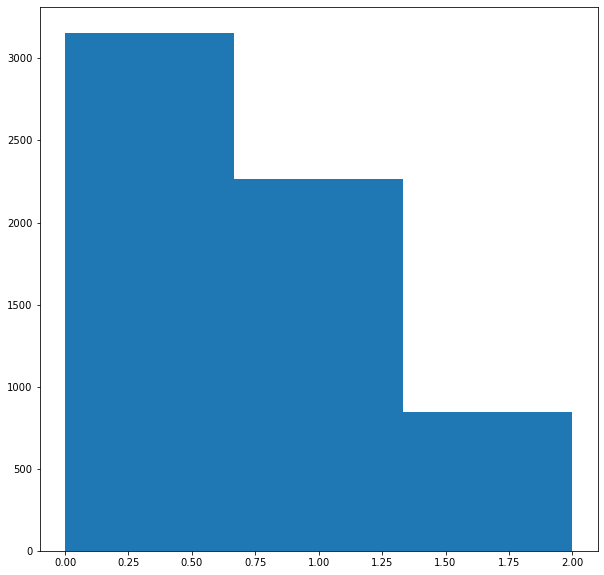

In [135]:
plt.figure(figsize=(10,10))
plt.hist(y_test,3)
plt.show();

In [ ]:
plt.figure(figsize=(10,3))
plt.hist(y_train,10)
plt.show();

Visually the distributions are the same, which I think is important to make sure we are training the model on what it will see in the test set (and hopefully in the wild).

# Baseline Models TODO FIX
The base line model is a custom word embedding providing vectorized words to two layers of 1-D convolutional next networks. According to Chollet a 1-D CNN model can (if properly tuned) do well at text classification.

But the limitation is that if information in the text is highly dependend on the sequence of words, it will be limited. I think because sentiment in English can be highly determined not only by the words used but by the order in which they're used this model won't score well, but is a baseline of how well a simpler-to-train option could do.

TODO: add Reference quoting Chollet

In [137]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print("vocab_size is {}".format(vocab_size))

vocab_size is 29095


In [139]:
target_names = list(range(3))
target_names = [str(thing+1) for thing in target_names]


In [140]:
#sorted(sklearn.metrics.SCORERS.keys())

## Random Forest Baseline

In [141]:
########################################################################
##
## TODO: UNCOMMENT THIS AS ANOTHER BASELINE MODEL BEFORE FINAL CHECK IN
##
########################################################################
rf_baseline_model = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=32)
kfold_obj = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
rf_baseline_cv_results = cross_validate(rf_baseline_model, X_train_seq_pad, y_train, cv=kfold_obj, n_jobs=32)
rf_baseline_model.fit(X_train_seq_pad, y_train)

RandomForestClassifier(n_jobs=32, random_state=42)

In [142]:
rf_baseline_cv_results

{'fit_time': array([ 79.81720948, 118.53172994,  76.86232281, 117.34441686,
         77.65339732]),
 'score_time': array([34.03170061,  0.37435198, 30.66624451,  0.68171597, 37.66866231]),
 'test_score': array([0.508252  , 0.50221828, 0.49591837, 0.50621118, 0.51206744])}

In [143]:
y_pred_rf = rf_baseline_model.predict(X_test_seq_pad)


In [144]:
y_pred_rf[:3]

array([0, 0, 0])

In [145]:
#target_names is expected to be a string
print(classification_report(y_test, y_pred_rf, target_names=target_names))

              precision    recall  f1-score   support

           1       0.51      0.93      0.66      3154
           2       0.39      0.07      0.13      2264
           3       0.00      0.00      0.00       844

    accuracy                           0.50      6262
   macro avg       0.30      0.34      0.26      6262
weighted avg       0.40      0.50      0.38      6262



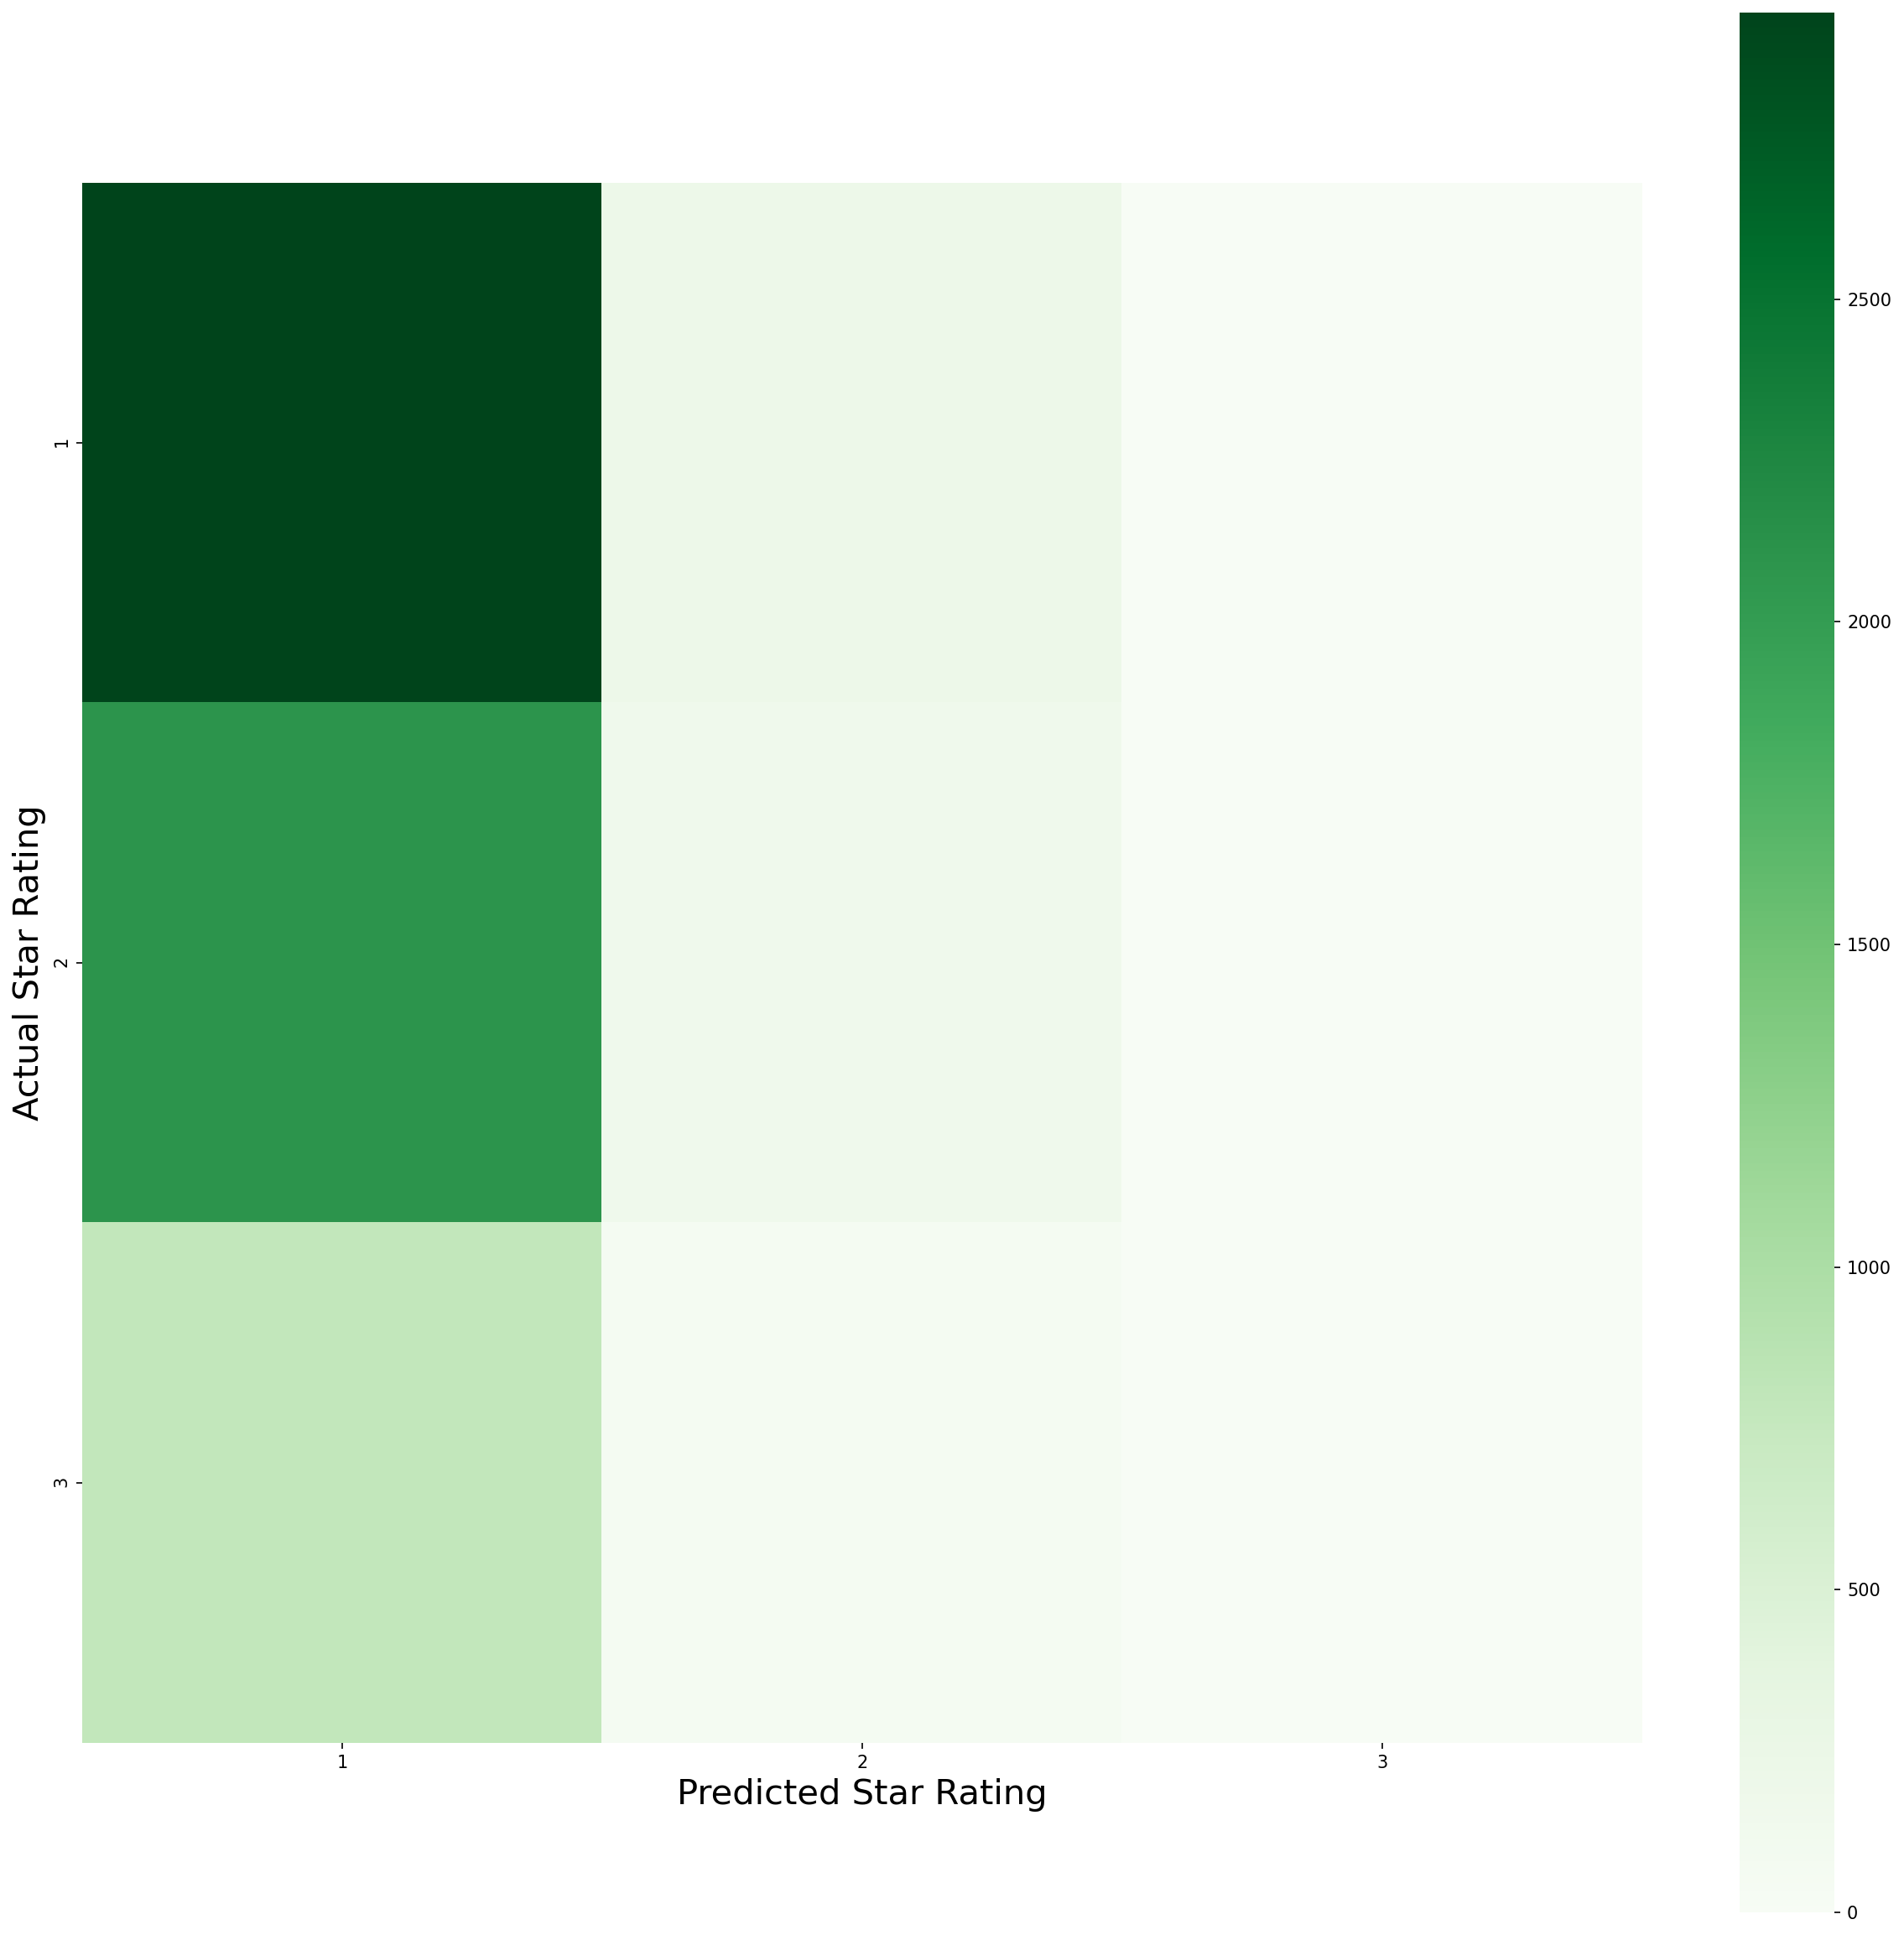

In [216]:
rf_confusion = confusion_matrix(y_test, y_pred_rf)
plt.figure(dpi=150,figsize=(20,20))
sns.heatmap(rf_confusion, cmap=plt.cm.Greens, square=True, 
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Star Rating", fontsize=20)
plt.ylabel("Actual Star Rating", fontsize=20)

plt.savefig("../Documents/Images/rf_confusion_matrix.png",dpi=400);

## CNN Baseline

**Class Weights**

In [147]:
base_model_class_weights_dict = {0:1, 1: 2.31, 2:2.31, 3:2.46, 4:2.309, 5:1.91, 6:1, 7:1, 8:1, 9:1}

In [151]:
baseline_model = Sequential()
baseline_model.add(Embedding(vocab_size, BASELINE_EMBEDDING_DIM, input_length=Max_Length))
baseline_model.add(Conv1D(32,7,activation="relu"))
baseline_model.add(MaxPooling1D(5))
baseline_model.add(Conv1D(32,7,activation="relu"))
baseline_model.add(GlobalMaxPooling1D())
baseline_model.add(Dense(15, activation="relu", kernel_regularizer=regularizers.l2(0.001)))
baseline_model.add(Dropout(0.2))
baseline_model.add(Dense(3, activation="softmax", kernel_regularizer=regularizers.l2(0.001)))

my_adam_optimizer = Adam(lr=0.01)

baseline_model.compile(optimizer=my_adam_optimizer, loss="sparse_categorical_crossentropy", metrics=["acc"])
baseline_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 7779, 32)          931040    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 7773, 32)          7200      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1554, 32)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1548, 32)          7200      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 15)                495       
_________________________________________________________________
dropout_2 (Dropout)          (None, 15)               

In [152]:
call_back_list = [
    keras.callbacks.ModelCheckpoint(
        filepath = "../Data/baseline_model.h5",
        monitor = "val_acc",
        save_best_only = True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor = "val_acc",
        factor = 0.1,
        patience = 3
    ),
    keras.callbacks.EarlyStopping(patience=15, verbose=1,restore_best_weights=True)
    
    
]

In [153]:
training_history = baseline_model.fit(X_train_seq_pad,
                                      y_train,
                                      epochs=EPOCHS,
                                      batch_size=BATCH_SIZE,
                                      callbacks=call_back_list,
                                      validation_split=Test_Size, 
                                      verbose=1)

Epoch 1/100
529/529 [==============================] - 32s 61ms/step - loss: 0.7180 - acc: 0.6785 - val_loss: 0.6518 - val_acc: 0.6997 - lr: 0.0100
Epoch 2/100
529/529 [==============================] - 32s 60ms/step - loss: 0.5895 - acc: 0.7437 - val_loss: 0.6376 - val_acc: 0.7145 - lr: 0.0100
Epoch 3/100
529/529 [==============================] - 32s 60ms/step - loss: 0.5237 - acc: 0.7722 - val_loss: 0.6441 - val_acc: 0.7230 - lr: 0.0100
Epoch 4/100
529/529 [==============================] - 32s 60ms/step - loss: 0.4712 - acc: 0.7977 - val_loss: 0.7021 - val_acc: 0.7118 - lr: 0.0100
Epoch 5/100
529/529 [==============================] - 32s 60ms/step - loss: 0.4162 - acc: 0.8236 - val_loss: 0.7778 - val_acc: 0.7159 - lr: 0.0100
Epoch 6/100
529/529 [==============================] - 32s 60ms/step - loss: 0.3780 - acc: 0.8421 - val_loss: 0.9525 - val_acc: 0.7013 - lr: 0.0100
Epoch 7/100
529/529 [==============================] - 32s 61ms/step - loss: 0.2822 - acc: 0.8881 - val_loss: 1.

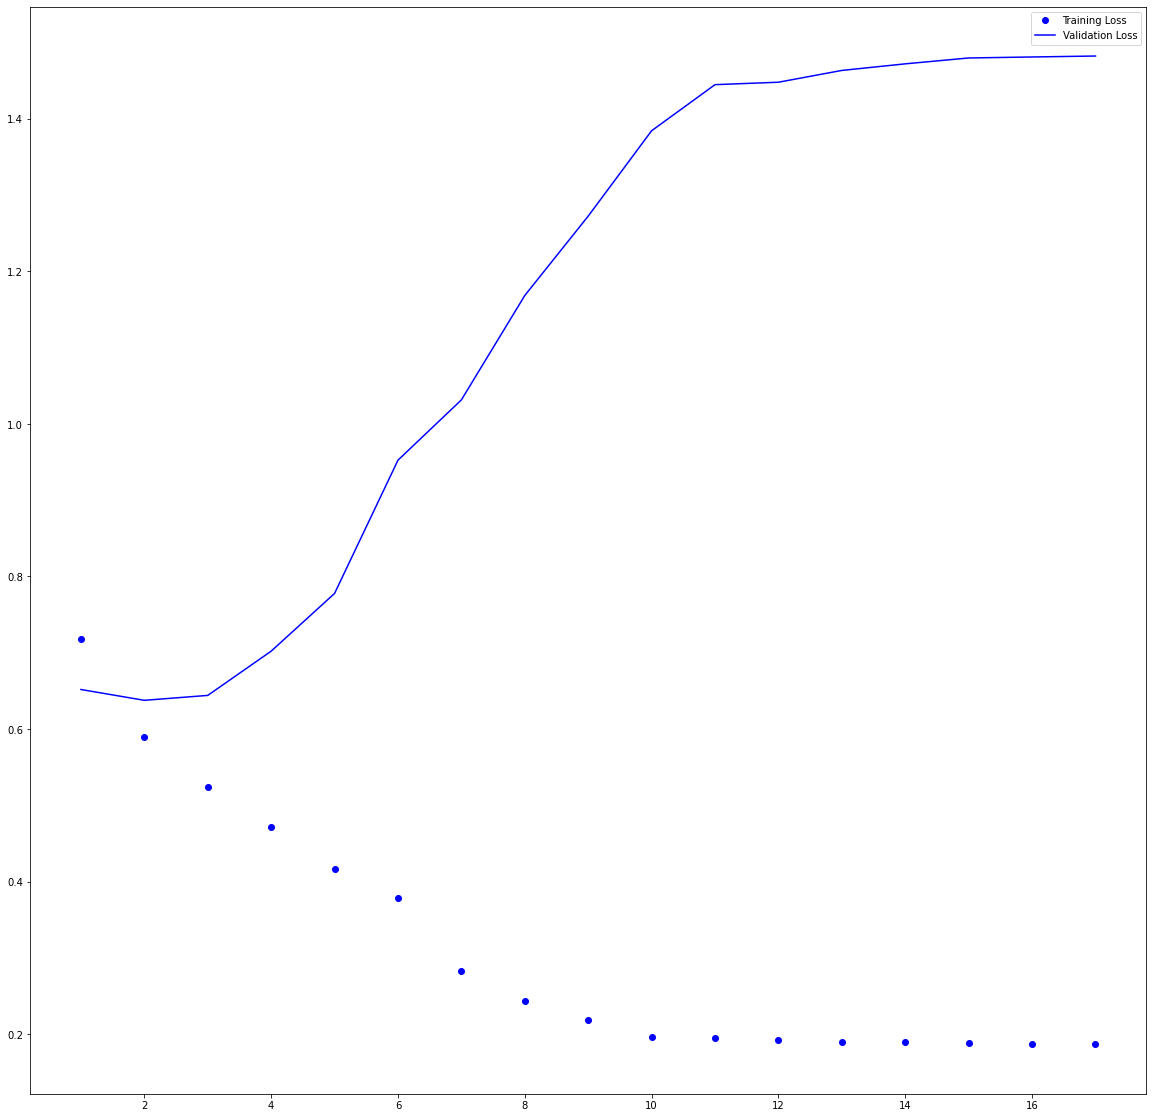

In [155]:
loss = training_history.history["loss"]
val_loss = training_history.history["val_loss"]
acc = training_history.history["acc"]
val_acc = training_history.history["val_acc"]
epochs = range(1,len(loss)+1)

plt.figure(figsize=(20,20))
plt.plot(epochs, loss,"bo",label="Training Loss")
plt.plot(epochs, val_loss,"b",label="Validation Loss")

plt.legend()
#plt.show()
plt.savefig("../Documents/Images/loss_curves.png",dpi=400)


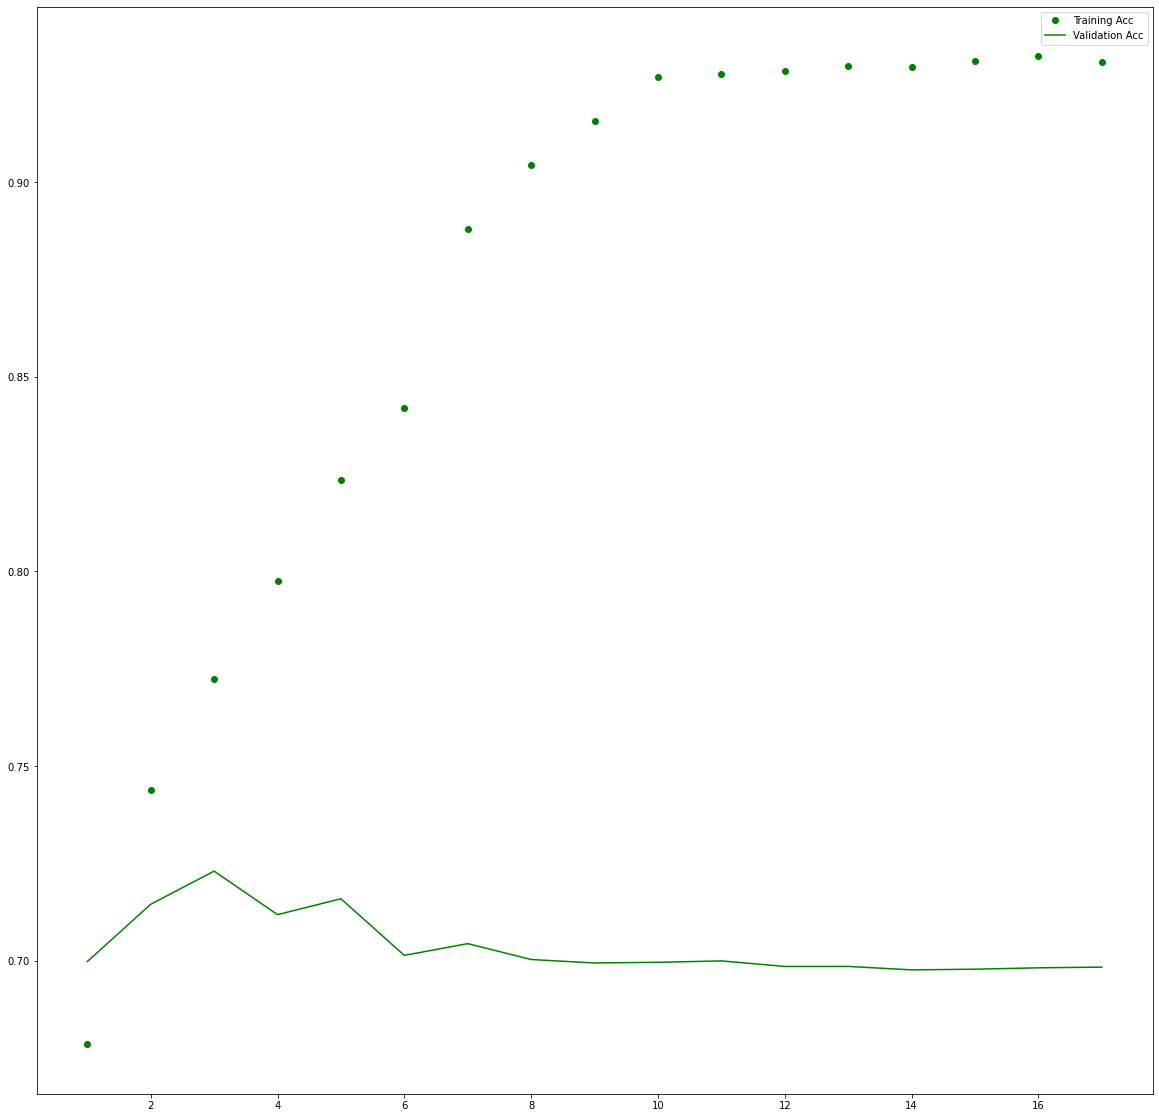

In [156]:
plt.figure(figsize=(20,20))
plt.plot(epochs, acc,"go",label="Training Acc")
plt.plot(epochs, val_acc,"g",label="Validation Acc")
plt.legend()
#plt.show()
plt.savefig("../Documents/Images/accuracy_curves.png",dpi=400)

In [157]:
y_pred_baseline = baseline_model.predict(X_test_seq_pad)
y_pred_baseline = [np.argmax(y_thing) for y_thing in y_pred_baseline]


In [158]:
#target_names = list(range(10))
#target_names = [str(thing+1) for thing in target_names]


In [159]:
#target_names is expected to be a string
print(classification_report(y_test, y_pred_baseline, target_names=target_names))

              precision    recall  f1-score   support

           1       0.89      0.78      0.83      3154
           2       0.57      0.87      0.69      2264
           3       0.59      0.05      0.09       844

    accuracy                           0.71      6262
   macro avg       0.69      0.57      0.54      6262
weighted avg       0.74      0.71      0.68      6262



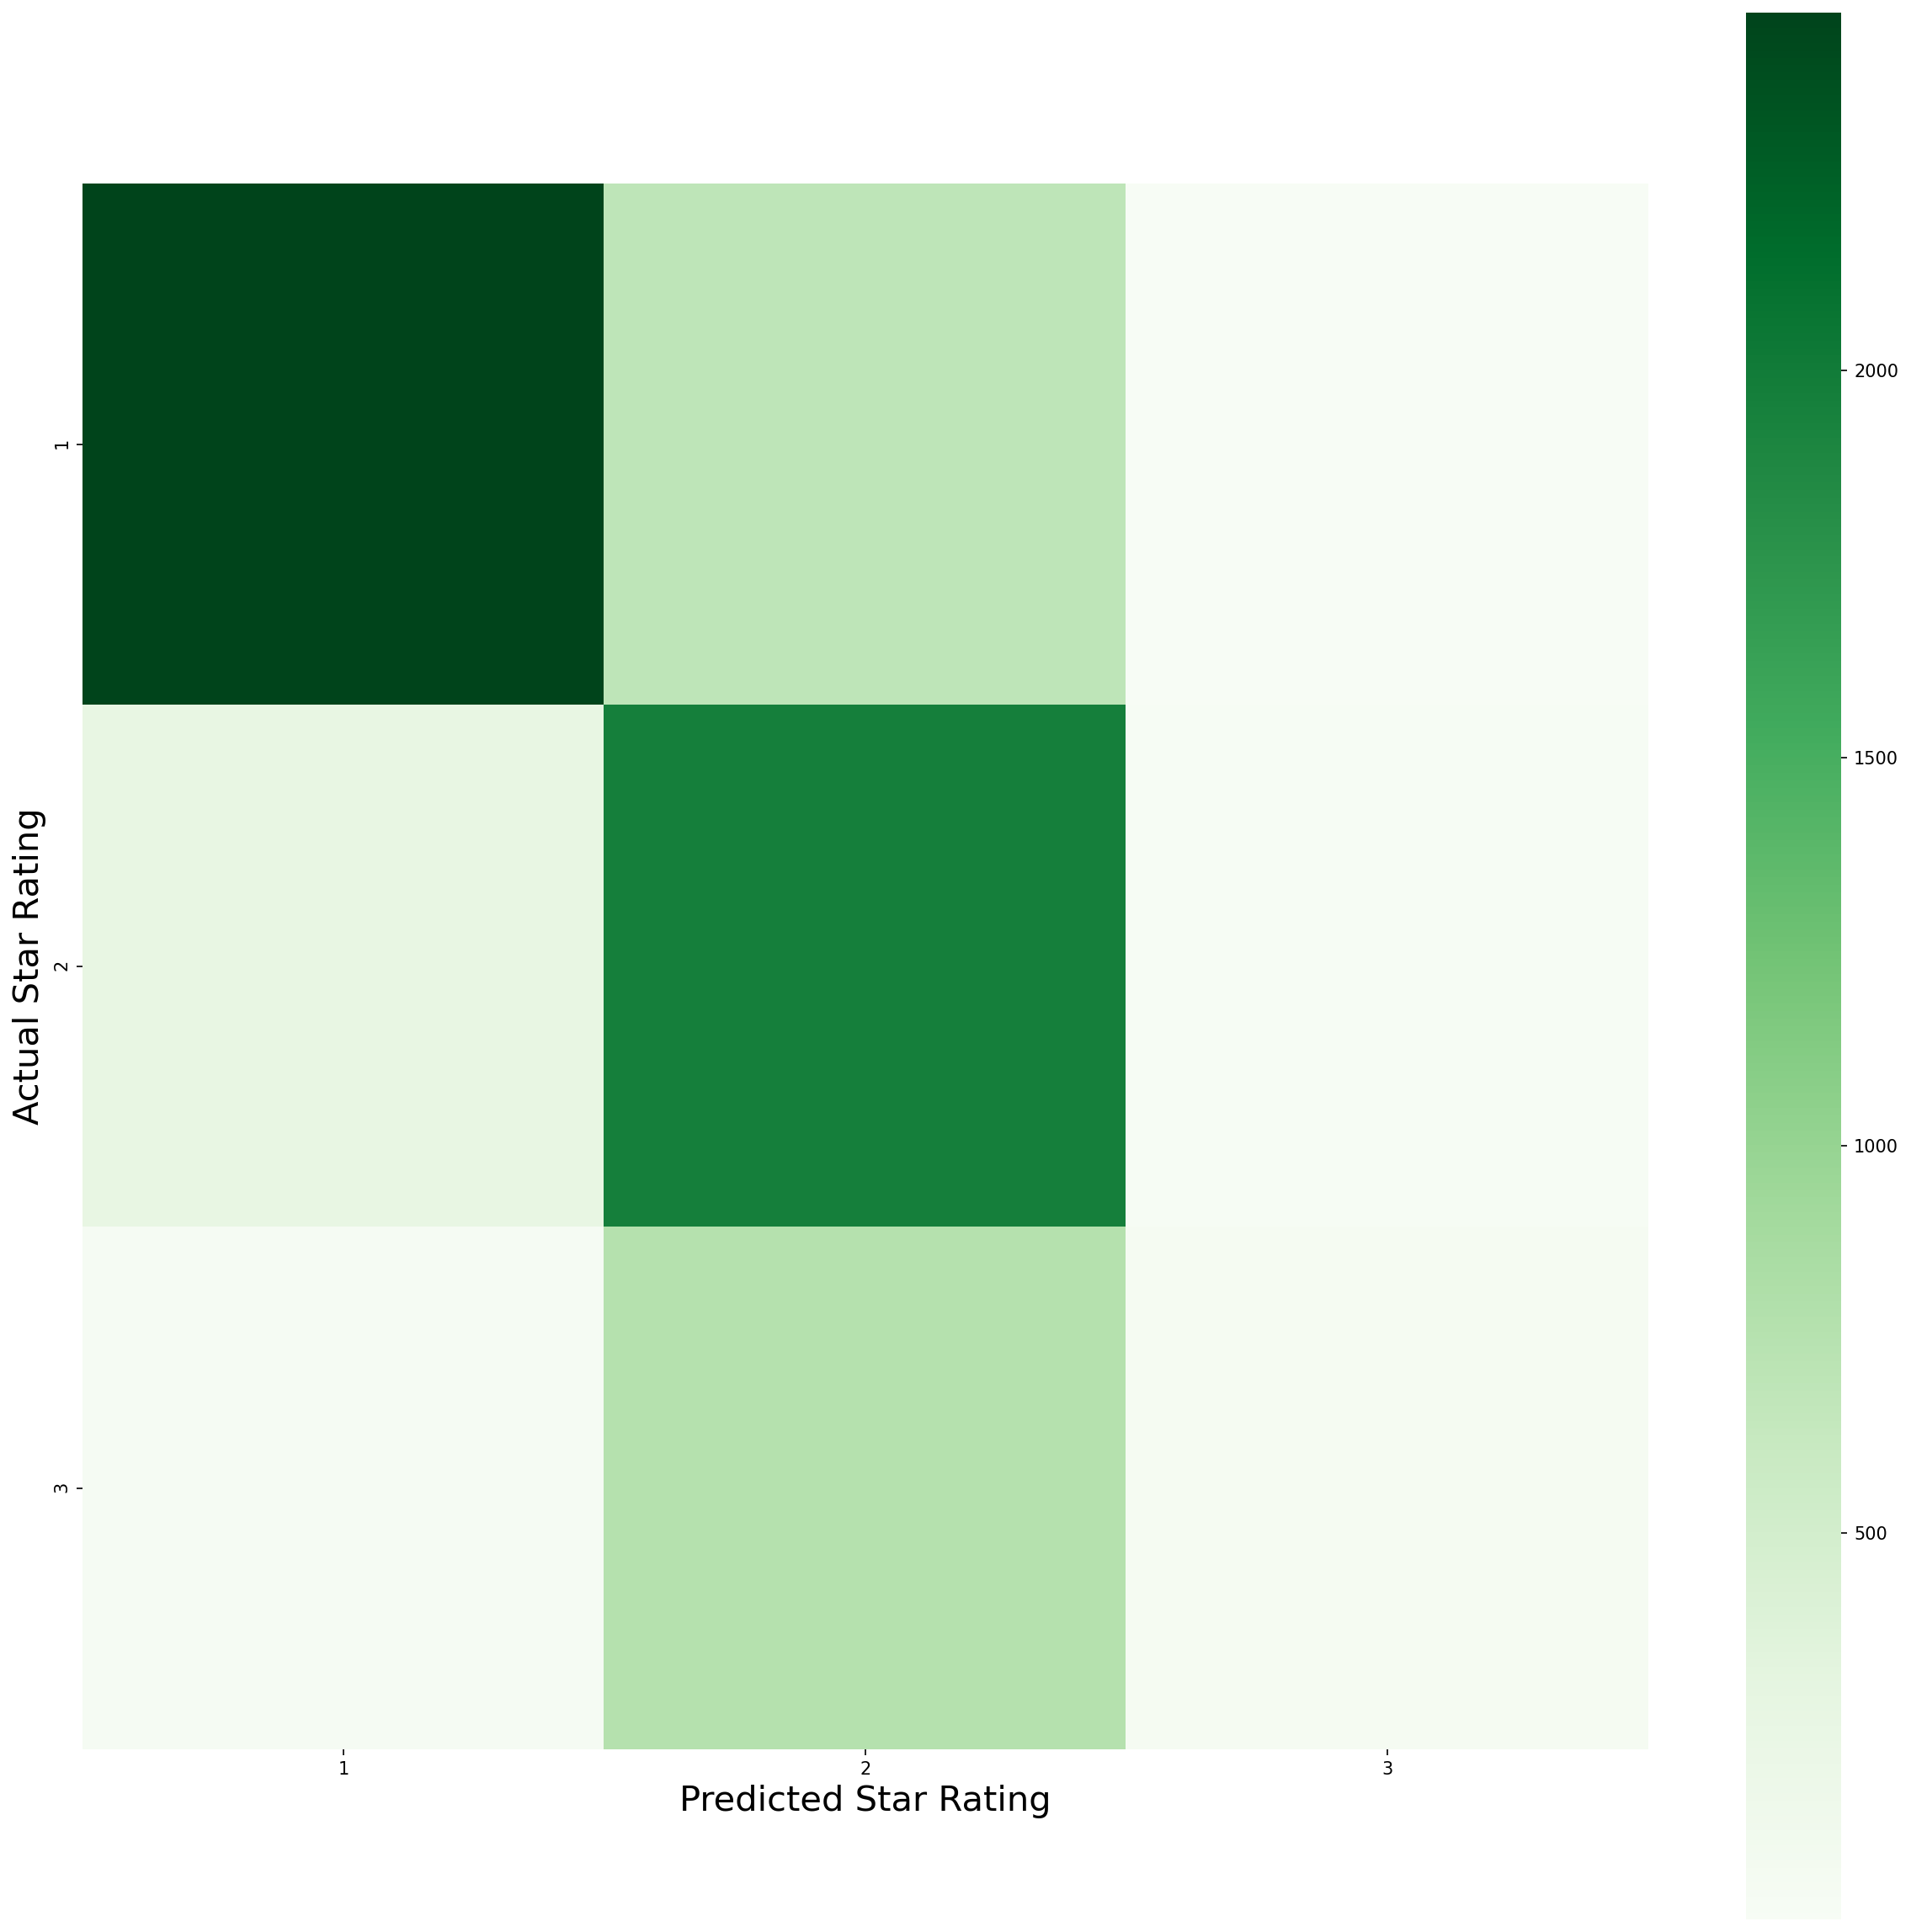

In [215]:
baseline_model_confusion = confusion_matrix(y_test, y_pred_baseline)
plt.figure(dpi=150,figsize=(20,20))
sns.heatmap(baseline_model_confusion, cmap=plt.cm.Greens, square=True, 
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Star Rating", fontsize=20)
plt.ylabel("Actual Star Rating", fontsize=20)
plt.savefig("../Documents/Images/baseline_confusion_matrix.png",dpi=400);

Huge overfit!

Things I need to try:

* Collect more data
* Use a pretrained word embedding
* Regularize
* Add callbacks to make training work harder for me
* which should I use as a loss function: `sparse_categorical_crossentropy` or `categorical_crossentropy`
* Which optimizer should I use: `adam` or `RMSprop(lr=0.1)`
* maybe lemmatization is limiting the ability of the model to distinguish a 0 rating and a 1 rating. I 1 rating may be called "bad" but a zero rating will be called "worst" If you lemmatize both "worst" and "bad" get converted to "bad"

**TODO**:
Find out what it means when val_loss improves by val_acc does not improve.

**ANSWER**
Loss can improve if the proba outputs improve yet do not result in a change in prediction -- hence the loss can improve but if the proba don't flip the decision to the right prediction then accuracy will not improve.

**ANSWER**
You should use `sparse_categorical_crossentropy`


## Test Example

In [161]:
score, acc = baseline_model.evaluate(X_test_seq_pad, y_test, batch_size=BATCH_SIZE)

66/66 [==============================] - 1s 21ms/step - loss: 0.6380 - acc: 0.7140


In [162]:
print(score)

0.6379936337471008


In [163]:
print(acc)

0.7139891386032104


In [239]:
#Saving model
baseline_model.save("../Data/baseline_model_arch_weights.h5")

# Updated Model
Will have a model with the following features:

* Pretrained word embedding
* LSTM (or GRU)
* Possibliy bidirectional
* More regularization
* If training is too long: Opt for GRU. Also may opt for a CNN+RNN hybrid


### Pretrained Word Embedding

In [164]:
!./get_word_vectors.sh


File is already downloaded
Done.
Thank you.
Bye.


In [165]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print("vocab_size is {}".format(vocab_size))

vocab_size is 29095


In [166]:
#build embedding matrix




embedding_dict = {}

GLOVE6B300_FILE = open("../Data/glove.6B.100d.txt","r")

for line in GLOVE6B300_FILE:
    line_values = line.split(" ")
    word = line_values[0]
    vector_components = np.asarray(line_values[1:], dtype="float32")
    embedding_dict[word] = vector_components

Embedding_Matrix = np.zeros((vocab_size, GLOVE_EMBEDDING_DIM))

for word, index_value in word_index.items():
    embedding_vector = embedding_dict.get(word)
    
    if embedding_vector is not None:
        Embedding_Matrix[index_value] = embedding_vector



In [167]:
Embedding_Matrix.shape

(29095, 100)

### Multi Level (DEEP) LSTM Model

Warning: This model takes 1 hour / epic to train and the early `val_acc` is 0.15. You can skip to the next model.

In [ ]:
updated_model = Sequential()
updated_model.add(Embedding(vocab_size, GLOVE_EMBEDDING_DIM, input_length=Max_Length, weights=[Embedding_Matrix], trainable=False))
updated_model.add(LSTM(128, return_sequences=True))
updated_model.add(LSTM(128, return_sequences=True))
updated_model.add(LSTM(64))
updated_model.add(Dense(32, activation="relu"))
updated_model.add(Dense(10, activation="softmax"))

my_adam_optimizer = Adam(lr=0.025)
updated_model.compile(optimizer=my_adam_optimizer, loss="sparse_categorical_crossentropy", metrics=["acc"])
updated_model.summary()

In [ ]:
call_back_list2 = [
    keras.callbacks.ModelCheckpoint(
        filepath = "../Data/updated_model.h5",
        monitor = "val_acc",
        save_best_only = True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor = "val_acc",
        factor = 0.1,
        patience = 3
    ),
    keras.callbacks.EarlyStopping(patience=15, verbose=1,restore_best_weights=True)
    
    
]

In [ ]:
training_history2 = updated_model.fit(X_train_seq_pad,
                                      y_train,
                                      epochs=EPOCHS,
                                      batch_size=BATCH_SIZE,
                                      callbacks=call_back_list2,
                                      validation_split=Test_Size, 
                                      verbose=1)

Just _one_ epic takes over an hour. Will try a smaller model.

In [ ]:
#loss = training_history2.history["loss"]
#val_loss = training_history2.history["val_loss"]
#acc = training_history2.history["acc"]
#val_acc = training_history2.history["val_acc"]
#epochs = range(1,len(loss)+1)

#plt.figure(figsize=(20,20))
#plt.plot(epochs, loss,"bo",label="Training Loss")
#plt.plot(epochs, val_loss,"b",label="Validation Loss")

#plt.legend()
#plt.show()
#plt.savefig("../Documents/Images/loss_curves2.png",dpi=400)

In [ ]:
#plt.figure(figsize=(20,20))
#plt.plot(epochs, acc,"go",label="Training Acc")
#plt.plot(epochs, val_acc,"g",label="Validation Acc")
#plt.legend()
#plt.show()
#plt.savefig("../Documents/Images/accuracy_curves2.png",dpi=400)

###  Less Complex LSTM Model

In [217]:
updated_model2 = Sequential()
updated_model2.add(Embedding(vocab_size, GLOVE_EMBEDDING_DIM, input_length=Max_Length, weights=[Embedding_Matrix], trainable=False))
updated_model2.add( Bidirectional( LSTM(128)) )
#updated_model2.add(Dense(128, activation="relu"))
#updated_model2.add(Dropout(0.2))
#updated_model2.add(Dense(64, activation="relu"))
#updated_model2.add(Dropout(0.2))
updated_model2.add(Dense(32, activation="relu"))
updated_model2.add(Dropout(0.2))
updated_model2.add(Dense(16, activation="relu"))
updated_model2.add(Dropout(0.2))
updated_model2.add(Dense(3, activation="softmax"))


my_adam_optimizer = Adam(lr=0.01)

updated_model2.compile(optimizer=my_adam_optimizer, loss="sparse_categorical_crossentropy", metrics=["acc"])
updated_model2.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 7779, 100)         2909500   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               234496    
_________________________________________________________________
dense_27 (Dense)             (None, 32)                8224      
_________________________________________________________________
dropout_14 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_15 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 3)               

In [218]:
call_back_list3 = [
    keras.callbacks.ModelCheckpoint(
        filepath = "../Data/updated_model2.h5",
        monitor = "val_acc",
        save_best_only = True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor = "val_acc",
        factor = 0.1,
        patience = 3
    ),
    keras.callbacks.EarlyStopping(patience=6, verbose=1,restore_best_weights=True)
    
    
]

In [219]:
training_history3 = updated_model2.fit(X_train_seq_pad,
                                      y_train,
                                      epochs=EPOCHS,
                                      batch_size=BATCH_SIZE,
                                      callbacks=call_back_list3,
                                      validation_split=Test_Size, 
                                      verbose=1)

Epoch 1/100
529/529 [==============================] - 337s 637ms/step - loss: 0.7661 - acc: 0.6562 - val_loss: 0.6843 - val_acc: 0.6983 - lr: 0.0100
Epoch 2/100
529/529 [==============================] - 338s 639ms/step - loss: 0.6618 - acc: 0.7120 - val_loss: 0.6619 - val_acc: 0.6994 - lr: 0.0100
Epoch 3/100
529/529 [==============================] - 338s 640ms/step - loss: 0.6230 - acc: 0.7267 - val_loss: 0.6105 - val_acc: 0.7311 - lr: 0.0100
Epoch 4/100
529/529 [==============================] - 338s 639ms/step - loss: 0.6016 - acc: 0.7378 - val_loss: 0.6282 - val_acc: 0.7166 - lr: 0.0100
Epoch 5/100
529/529 [==============================] - 338s 639ms/step - loss: 0.5843 - acc: 0.7430 - val_loss: 0.6311 - val_acc: 0.7171 - lr: 0.0100
Epoch 6/100
529/529 [==============================] - 336s 636ms/step - loss: 0.5683 - acc: 0.7524 - val_loss: 0.6303 - val_acc: 0.7256 - lr: 0.0100
Epoch 7/100
529/529 [==============================] - 337s 638ms/step - loss: 0.5160 - acc: 0.7752 

In [220]:
score, acc = updated_model2.evaluate(X_test_seq_pad, y_test, batch_size=BATCH_SIZE)

66/66 [==============================] - 17s 262ms/step - loss: 0.5970 - acc: 0.7389


In [221]:
print(score)

0.5969709753990173


In [222]:
print(acc)

0.7389013171195984


In [223]:
y_pred_updated_model2 = updated_model2.predict(X_test_seq_pad)
y_pred_updated_model2 = [np.argmax(y_thing) for y_thing in y_pred_updated_model2]


In [224]:
#target_names = list(range(10))
#target_names = [str(thing) for thing in target_names]


In [226]:
#target_names is expected to be a string
print(classification_report(y_test, y_pred_updated_model2, target_names=target_names))

              precision    recall  f1-score   support

           1       0.85      0.86      0.85      3154
           2       0.62      0.77      0.69      2264
           3       0.66      0.20      0.31       844

    accuracy                           0.74      6262
   macro avg       0.71      0.61      0.62      6262
weighted avg       0.74      0.74      0.72      6262



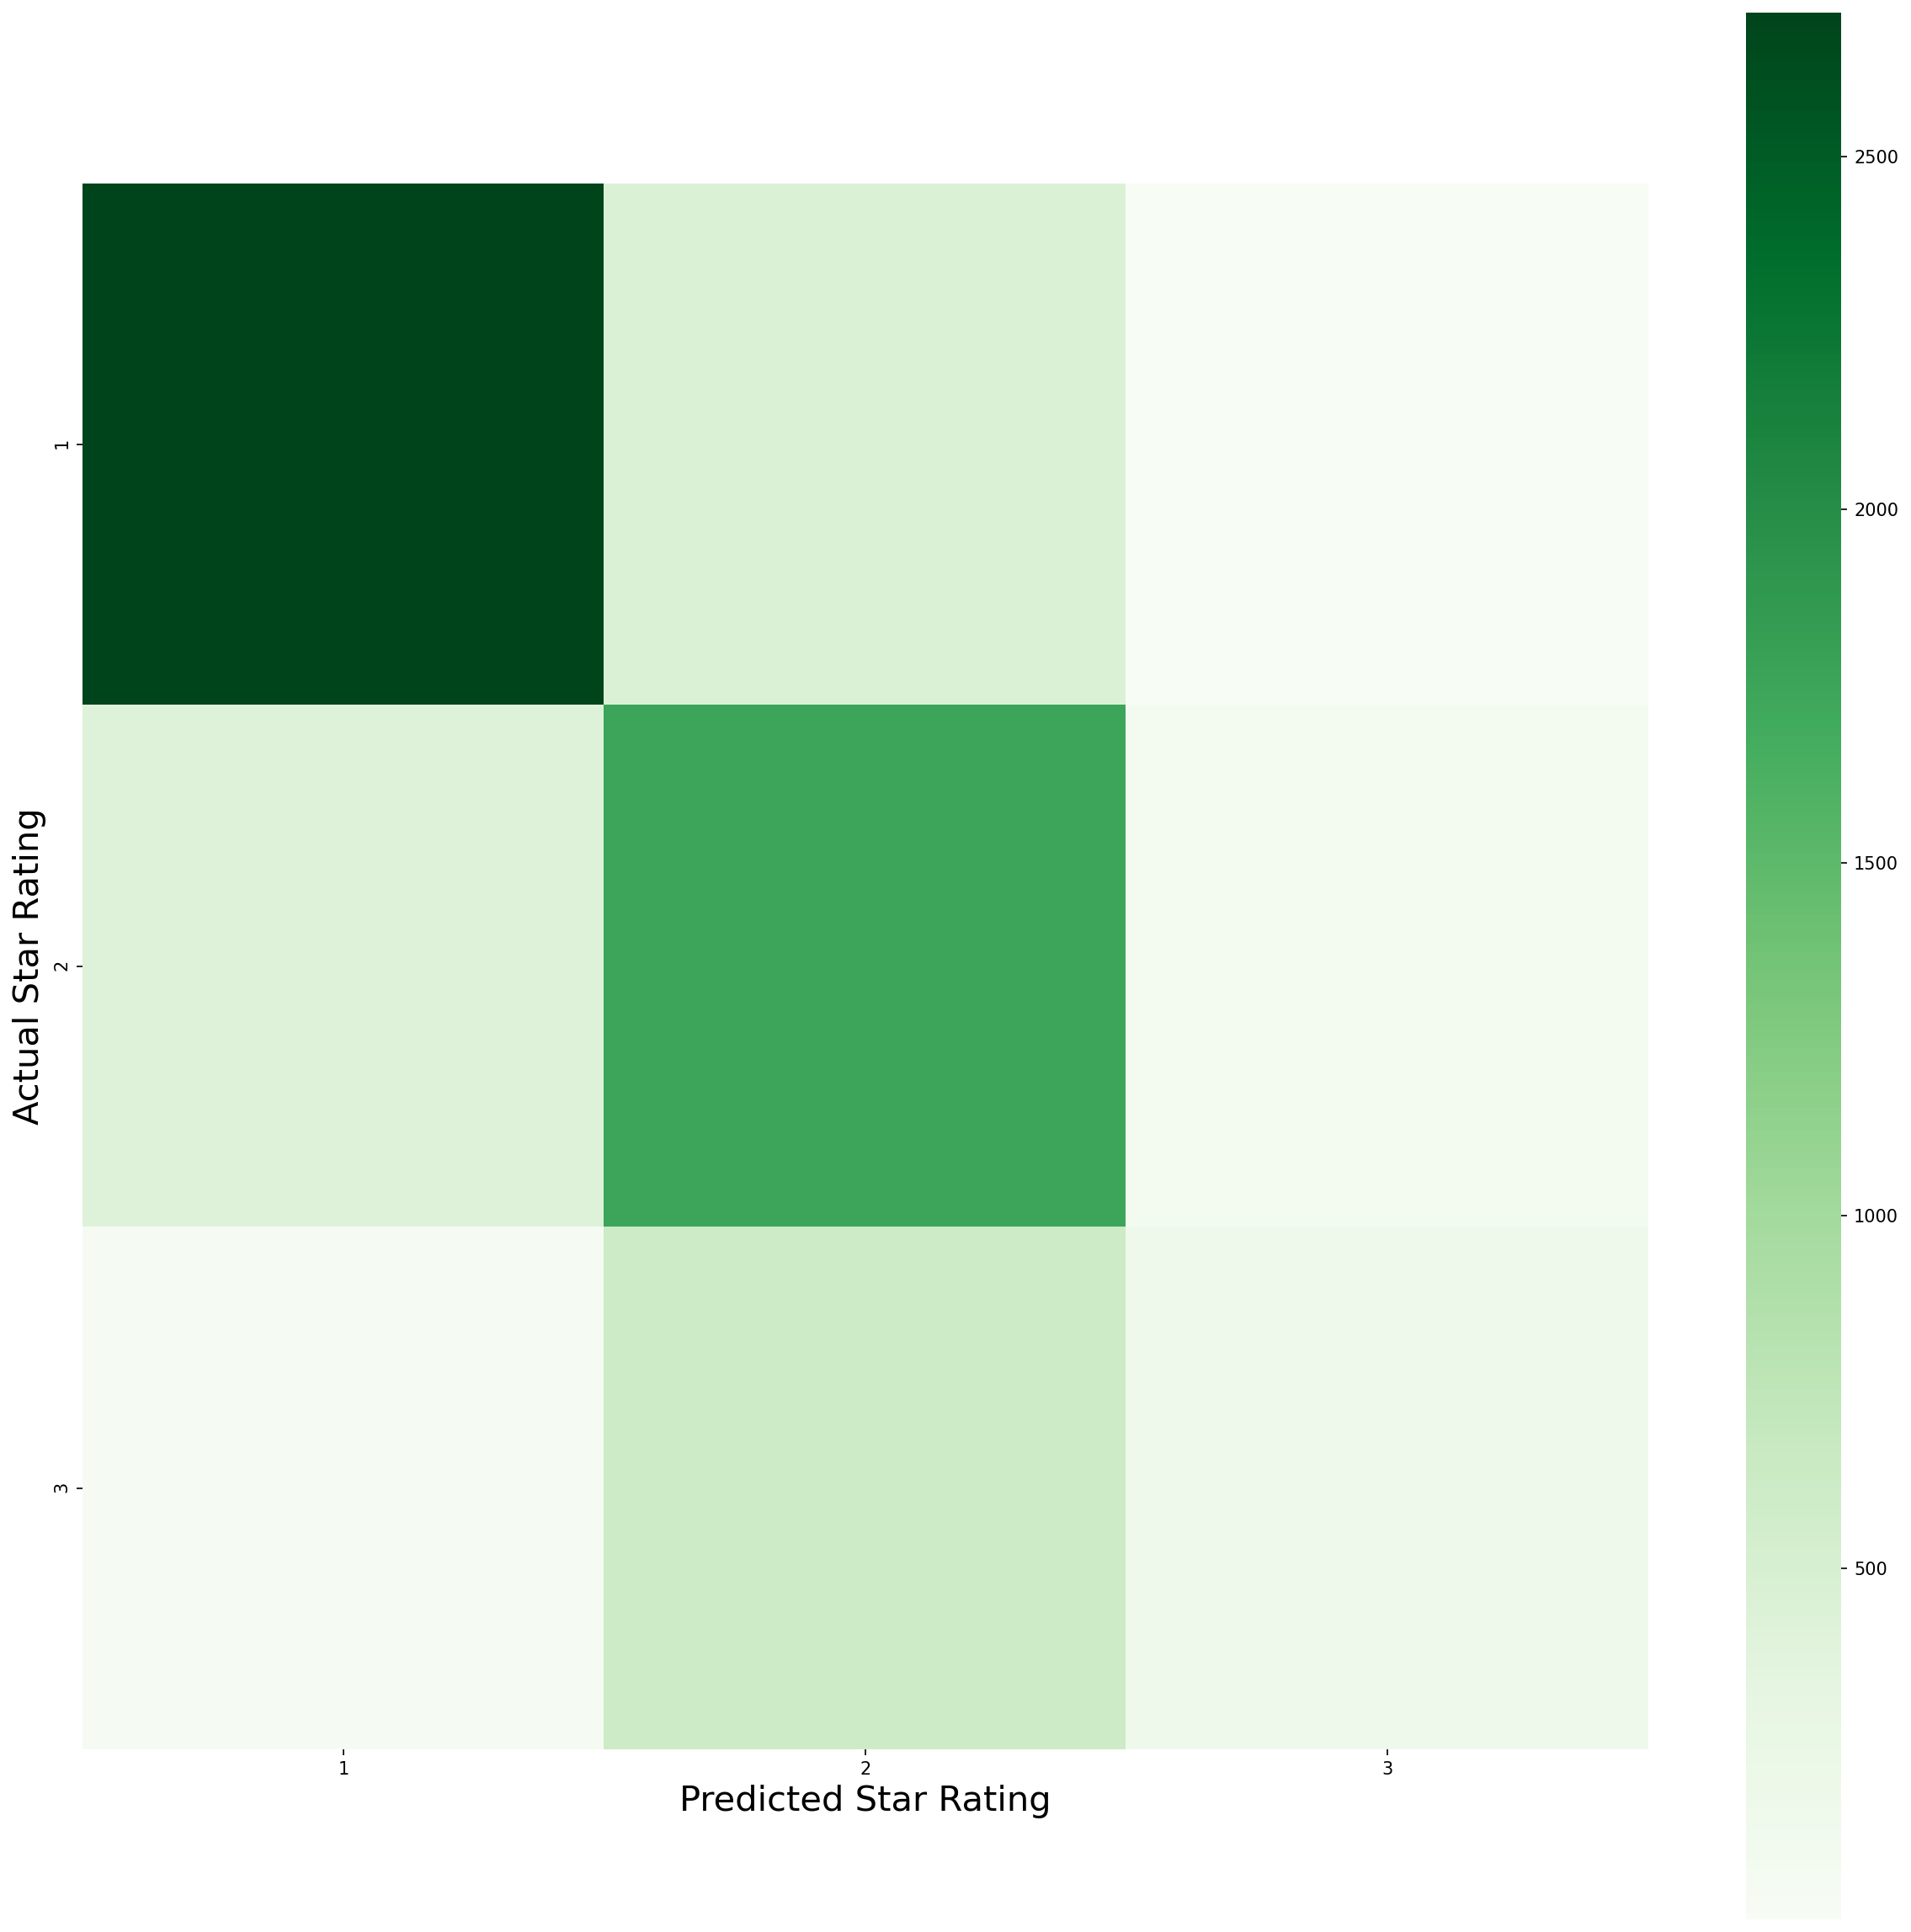

In [236]:
updated_model2_confusion = confusion_matrix(y_test, y_pred_updated_model2)
plt.figure(dpi=150,figsize=(20,20))
sns.heatmap(updated_model2_confusion, cmap=plt.cm.Greens, square=True, 
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Star Rating",fontsize=20)
plt.ylabel("Actual Star Rating", fontsize=20)
plt.savefig("../Documents/Images/updated_model2_confusion_matrix.png",dpi=400);

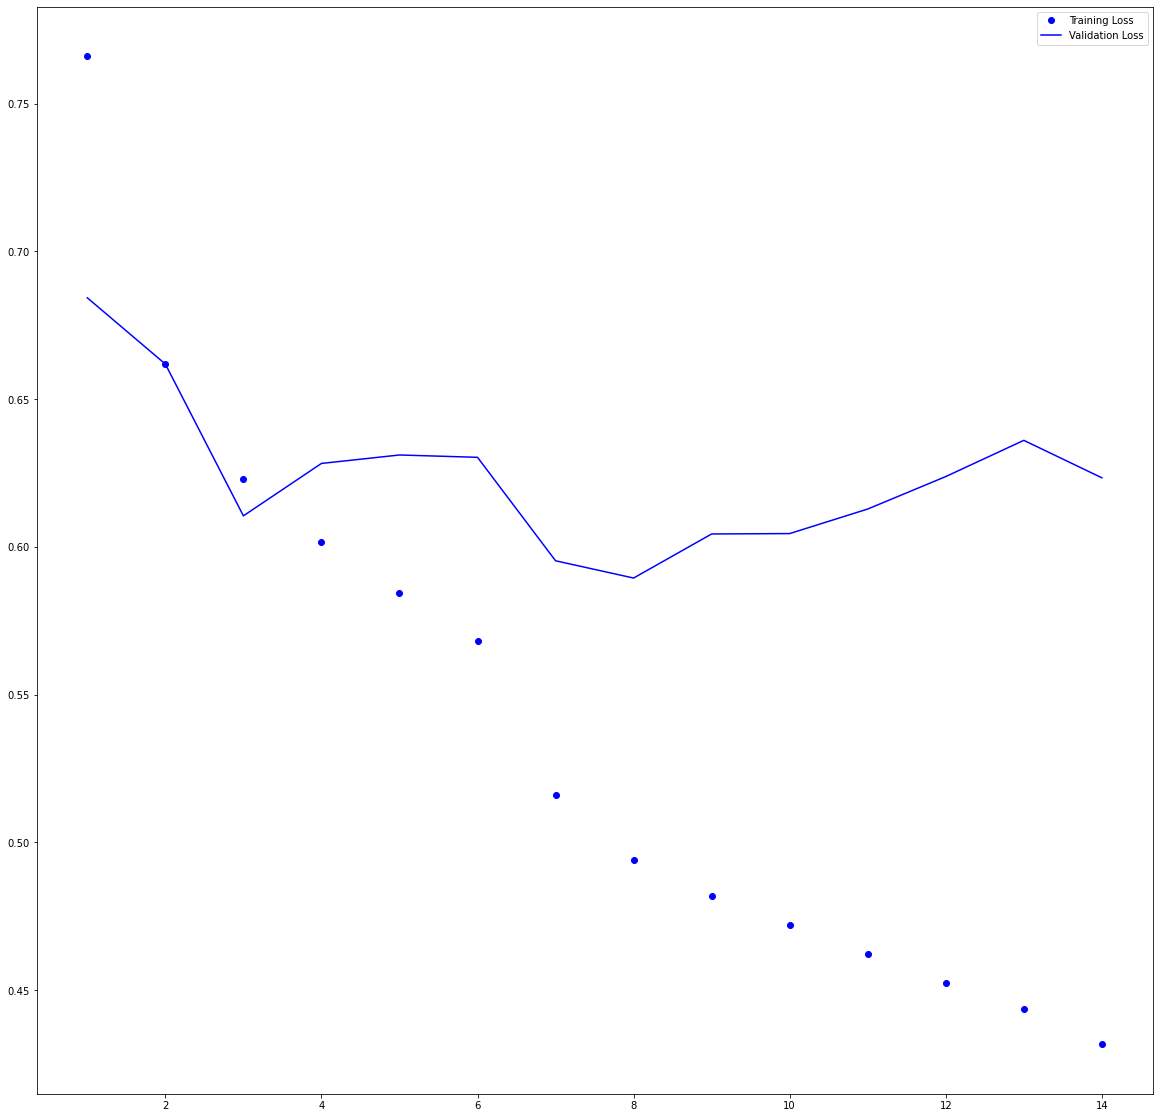

In [227]:
loss = training_history3.history["loss"]
val_loss = training_history3.history["val_loss"]
acc = training_history3.history["acc"]
val_acc = training_history3.history["val_acc"]
epochs = range(1,len(loss)+1)

plt.figure(figsize=(20,20))
plt.plot(epochs, loss,"bo",label="Training Loss")
plt.plot(epochs, val_loss,"b",label="Validation Loss")

plt.legend()
#plt.show()
plt.savefig("../Documents/Images/loss_curves_update_model2.png",dpi=400)

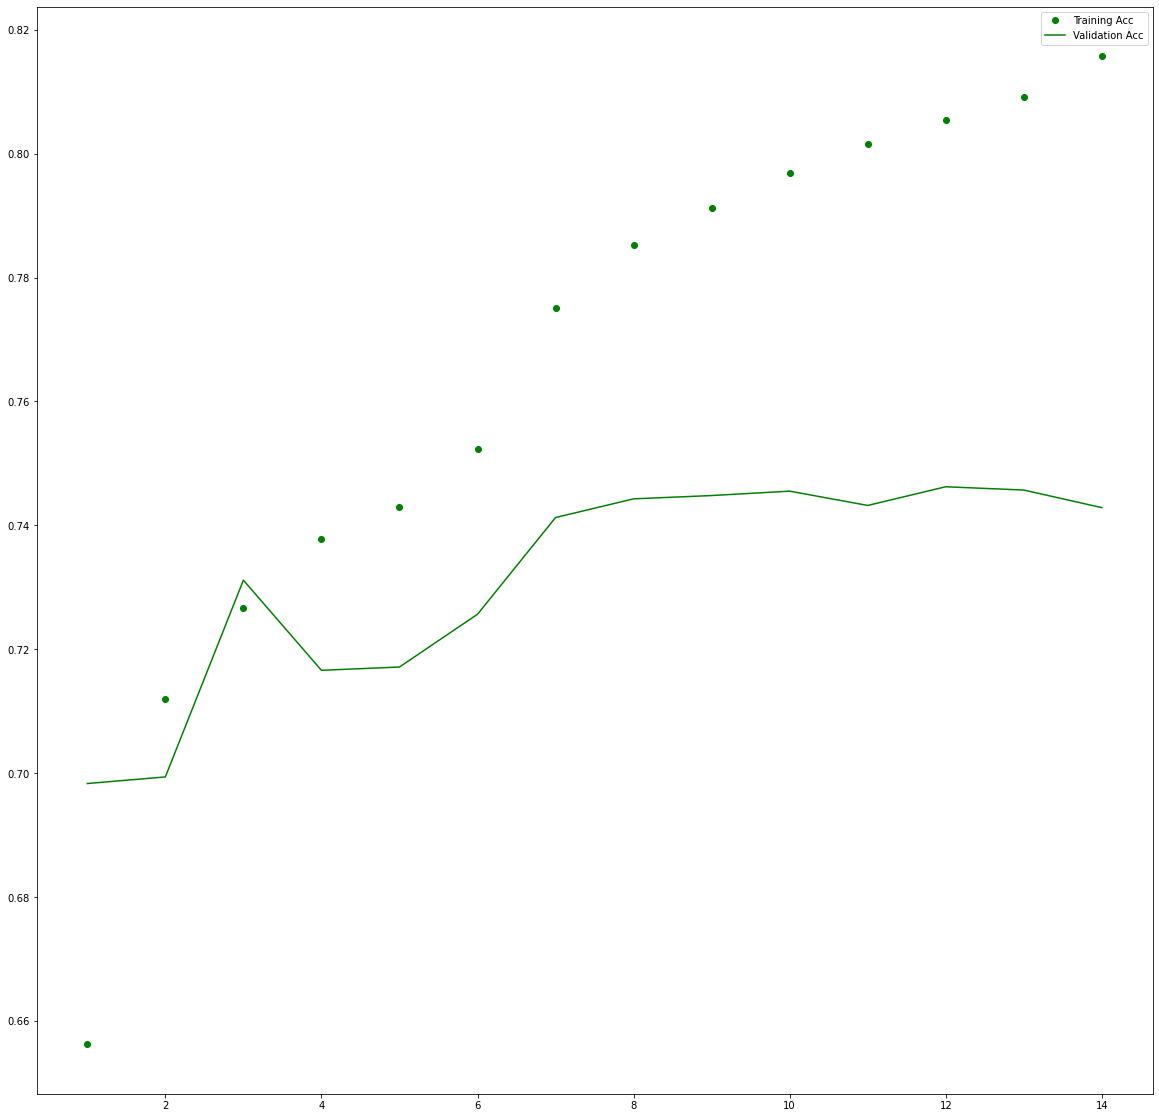

In [233]:
plt.figure(figsize=(20,20))
plt.plot(epochs, acc,"go",label="Training Acc")
plt.plot(epochs, val_acc,"g",label="Validation Acc")
plt.legend()
#plt.show()
plt.savefig("../Documents/Images/accuracy_curves_update_model2.png",dpi=400)

In [234]:
#Saving model
updated_model2.save("../Data/updated_model2_arch_weights")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../Data/updated_model2_arch_weights/assets


### More Complex CNN

In [178]:
baseline_model2 = Sequential()
baseline_model2.add(Embedding(vocab_size, BASELINE_EMBEDDING_DIM, input_length=Max_Length))
#baseline_model2.add(Conv1D(32,7,activation="relu",kernel_regularizer=regularizers.l2(0.001)))
baseline_model2.add(Conv1D(32,9,activation="relu",
           kernel_initializer=keras.initializers.glorot_normal(seed=RANDOM_STATE))
#           kernel_regularizer=regularizers.l2(0.0006))
    )
baseline_model2.add(MaxPooling1D(5))
#baseline_model2.add(Conv1D(32,7,activation="relu",kernel_regularizer=regularizers.l2(0.001)))
baseline_model2.add(
    Conv1D(32,
           9,
           activation="relu",
           kernel_initializer=keras.initializers.glorot_normal(seed=RANDOM_STATE))
#    kernel_regularizer=regularizers.l2(0.0007))
)
baseline_model2.add(MaxPooling1D(5))
baseline_model2.add(Conv1D(
    32,
    9,
    activation="relu",
    kernel_initializer=keras.initializers.glorot_normal(seed=RANDOM_STATE))
    #kernel_regularizer=regularizers.l2(0.0007))
)
#baseline_model2.add(GlobalMaxPooling1D())
baseline_model2.add(Flatten())
#baseline_model2.add(Dense(16, activation="relu", kernel_regularizer=regularizers.l2(0.015)))
baseline_model2.add(Dense(64, activation="relu"))
#baseline_model2.add(Dropout(0.2))
baseline_model2.add(Dense(32, activation="relu"))
#baseline_model2.add(Dropout(0.2))
baseline_model2.add(Dense(16, activation="relu"))
#baseline_model2.add(Dropout(0.2))
#baseline_model2.add(Dense(3, activation="softmax", kernel_regularizer=regularizers.l2(0.0007)))
baseline_model2.add(Dense(3, activation="softmax"))
my_adam_optimizer = Adam(lr=0.01)

baseline_model2.compile(optimizer=my_adam_optimizer, loss="sparse_categorical_crossentropy", metrics=["acc"])
baseline_model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 7779, 32)          931040    
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 7771, 32)          9248      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 1554, 32)          0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 1546, 32)          9248      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 309, 32)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 301, 32)           9248      
_________________________________________________________________
flatten_2 (Flatten)          (None, 9632)             

In [179]:
call_back_list4 = [
    keras.callbacks.ModelCheckpoint(
        filepath = "../Data/baseline_model2.h5",
        monitor = "val_acc",
        save_best_only = True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor = "val_acc",
        factor = 0.1,
        patience = 5
    ),
    keras.callbacks.EarlyStopping(patience=15, verbose=1,restore_best_weights=True)
    
    
]

In [180]:
training_history4 = baseline_model2.fit(X_train_seq_pad,
                                      y_train,
                                      epochs=EPOCHS,
                                      batch_size=BATCH_SIZE,
                                      callbacks=call_back_list4,
                                      validation_split=Test_Size, 
                                      verbose=1)

Epoch 1/100
529/529 [==============================] - 33s 62ms/step - loss: 0.7149 - acc: 0.6788 - val_loss: 0.6987 - val_acc: 0.6742 - lr: 0.0100
Epoch 2/100
529/529 [==============================] - 33s 62ms/step - loss: 0.6052 - acc: 0.7366 - val_loss: 0.6528 - val_acc: 0.7003 - lr: 0.0100
Epoch 3/100
529/529 [==============================] - 32s 61ms/step - loss: 0.5136 - acc: 0.7756 - val_loss: 0.6825 - val_acc: 0.7269 - lr: 0.0100
Epoch 4/100
529/529 [==============================] - 32s 61ms/step - loss: 0.4435 - acc: 0.8074 - val_loss: 0.7806 - val_acc: 0.7226 - lr: 0.0100
Epoch 5/100
529/529 [==============================] - 33s 62ms/step - loss: 0.3839 - acc: 0.8392 - val_loss: 0.7496 - val_acc: 0.7118 - lr: 0.0100
Epoch 6/100
529/529 [==============================] - 33s 62ms/step - loss: 0.3335 - acc: 0.8637 - val_loss: 0.7859 - val_acc: 0.6988 - lr: 0.0100
Epoch 7/100
529/529 [==============================] - 32s 61ms/step - loss: 0.2951 - acc: 0.8861 - val_loss: 1.

In [181]:
score, acc = baseline_model2.evaluate(X_test_seq_pad, y_test, batch_size=BATCH_SIZE)

66/66 [==============================] - 1s 22ms/step - loss: 0.6450 - acc: 0.7084


In [182]:
print(score)

0.6450287103652954


In [183]:
print(acc)

0.7083998918533325


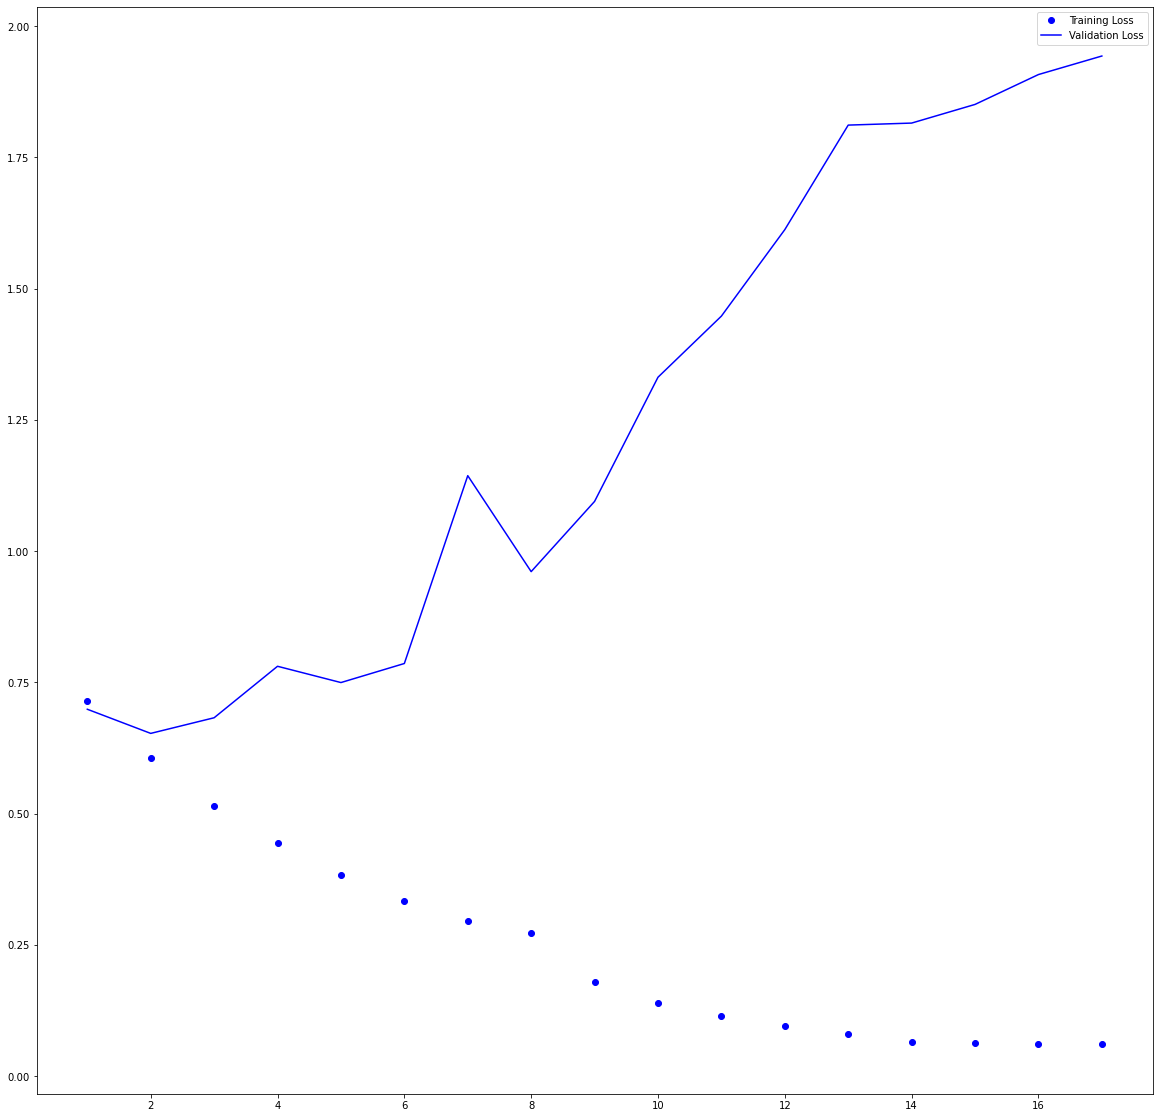

In [184]:
loss = training_history4.history["loss"]
val_loss = training_history4.history["val_loss"]
acc = training_history4.history["acc"]
val_acc = training_history4.history["val_acc"]
epochs = range(1,len(loss)+1)

plt.figure(figsize=(20,20))
plt.plot(epochs, loss,"bo",label="Training Loss")
plt.plot(epochs, val_loss,"b",label="Validation Loss")

plt.legend()
#plt.show()
plt.savefig("../Documents/Images/baseline_model2_loss_curves.png",dpi=400)


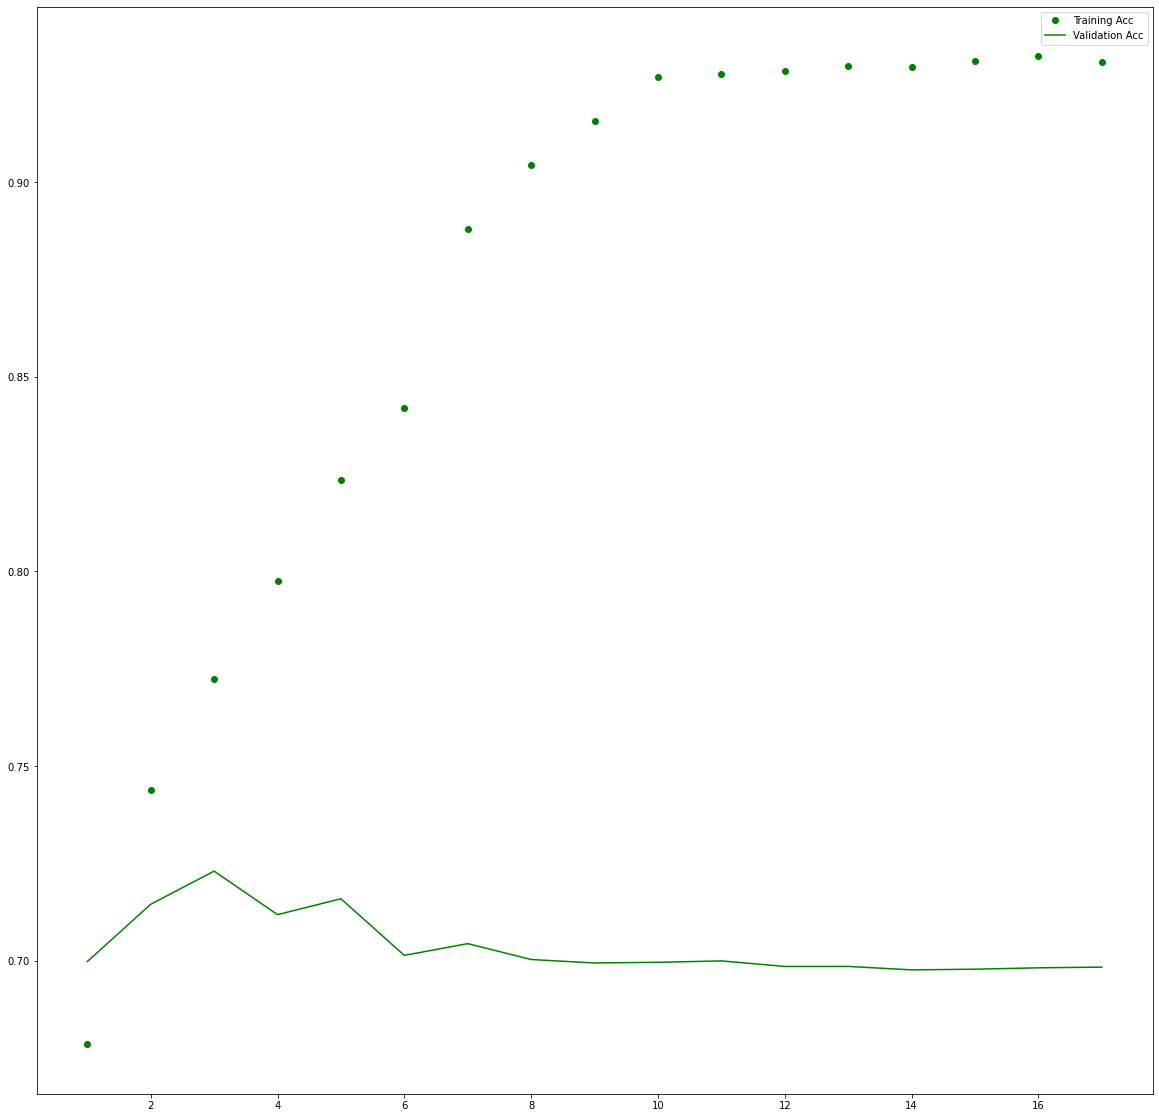

In [156]:
plt.figure(figsize=(20,20))
plt.plot(epochs, acc,"go",label="Training Acc")
plt.plot(epochs, val_acc,"g",label="Validation Acc")
plt.legend()
#plt.show()
plt.savefig("../Documents/Images/baseline_model2_accuracy_curves.png",dpi=400)

In [157]:
y_pred_baseline2 = baseline_model2.predict(X_test_seq_pad)
y_pred_baseline2 = [np.argmax(y_thing) for y_thing in y_pred_baseline2]


In [158]:
#target_names = list(range(10))
#target_names = [str(thing+1) for thing in target_names]


In [159]:
#target_names is expected to be a string
print(classification_report(y_test, y_pred_baseline2, target_names=target_names))

              precision    recall  f1-score   support

           1       0.89      0.78      0.83      3154
           2       0.57      0.87      0.69      2264
           3       0.59      0.05      0.09       844

    accuracy                           0.71      6262
   macro avg       0.69      0.57      0.54      6262
weighted avg       0.74      0.71      0.68      6262



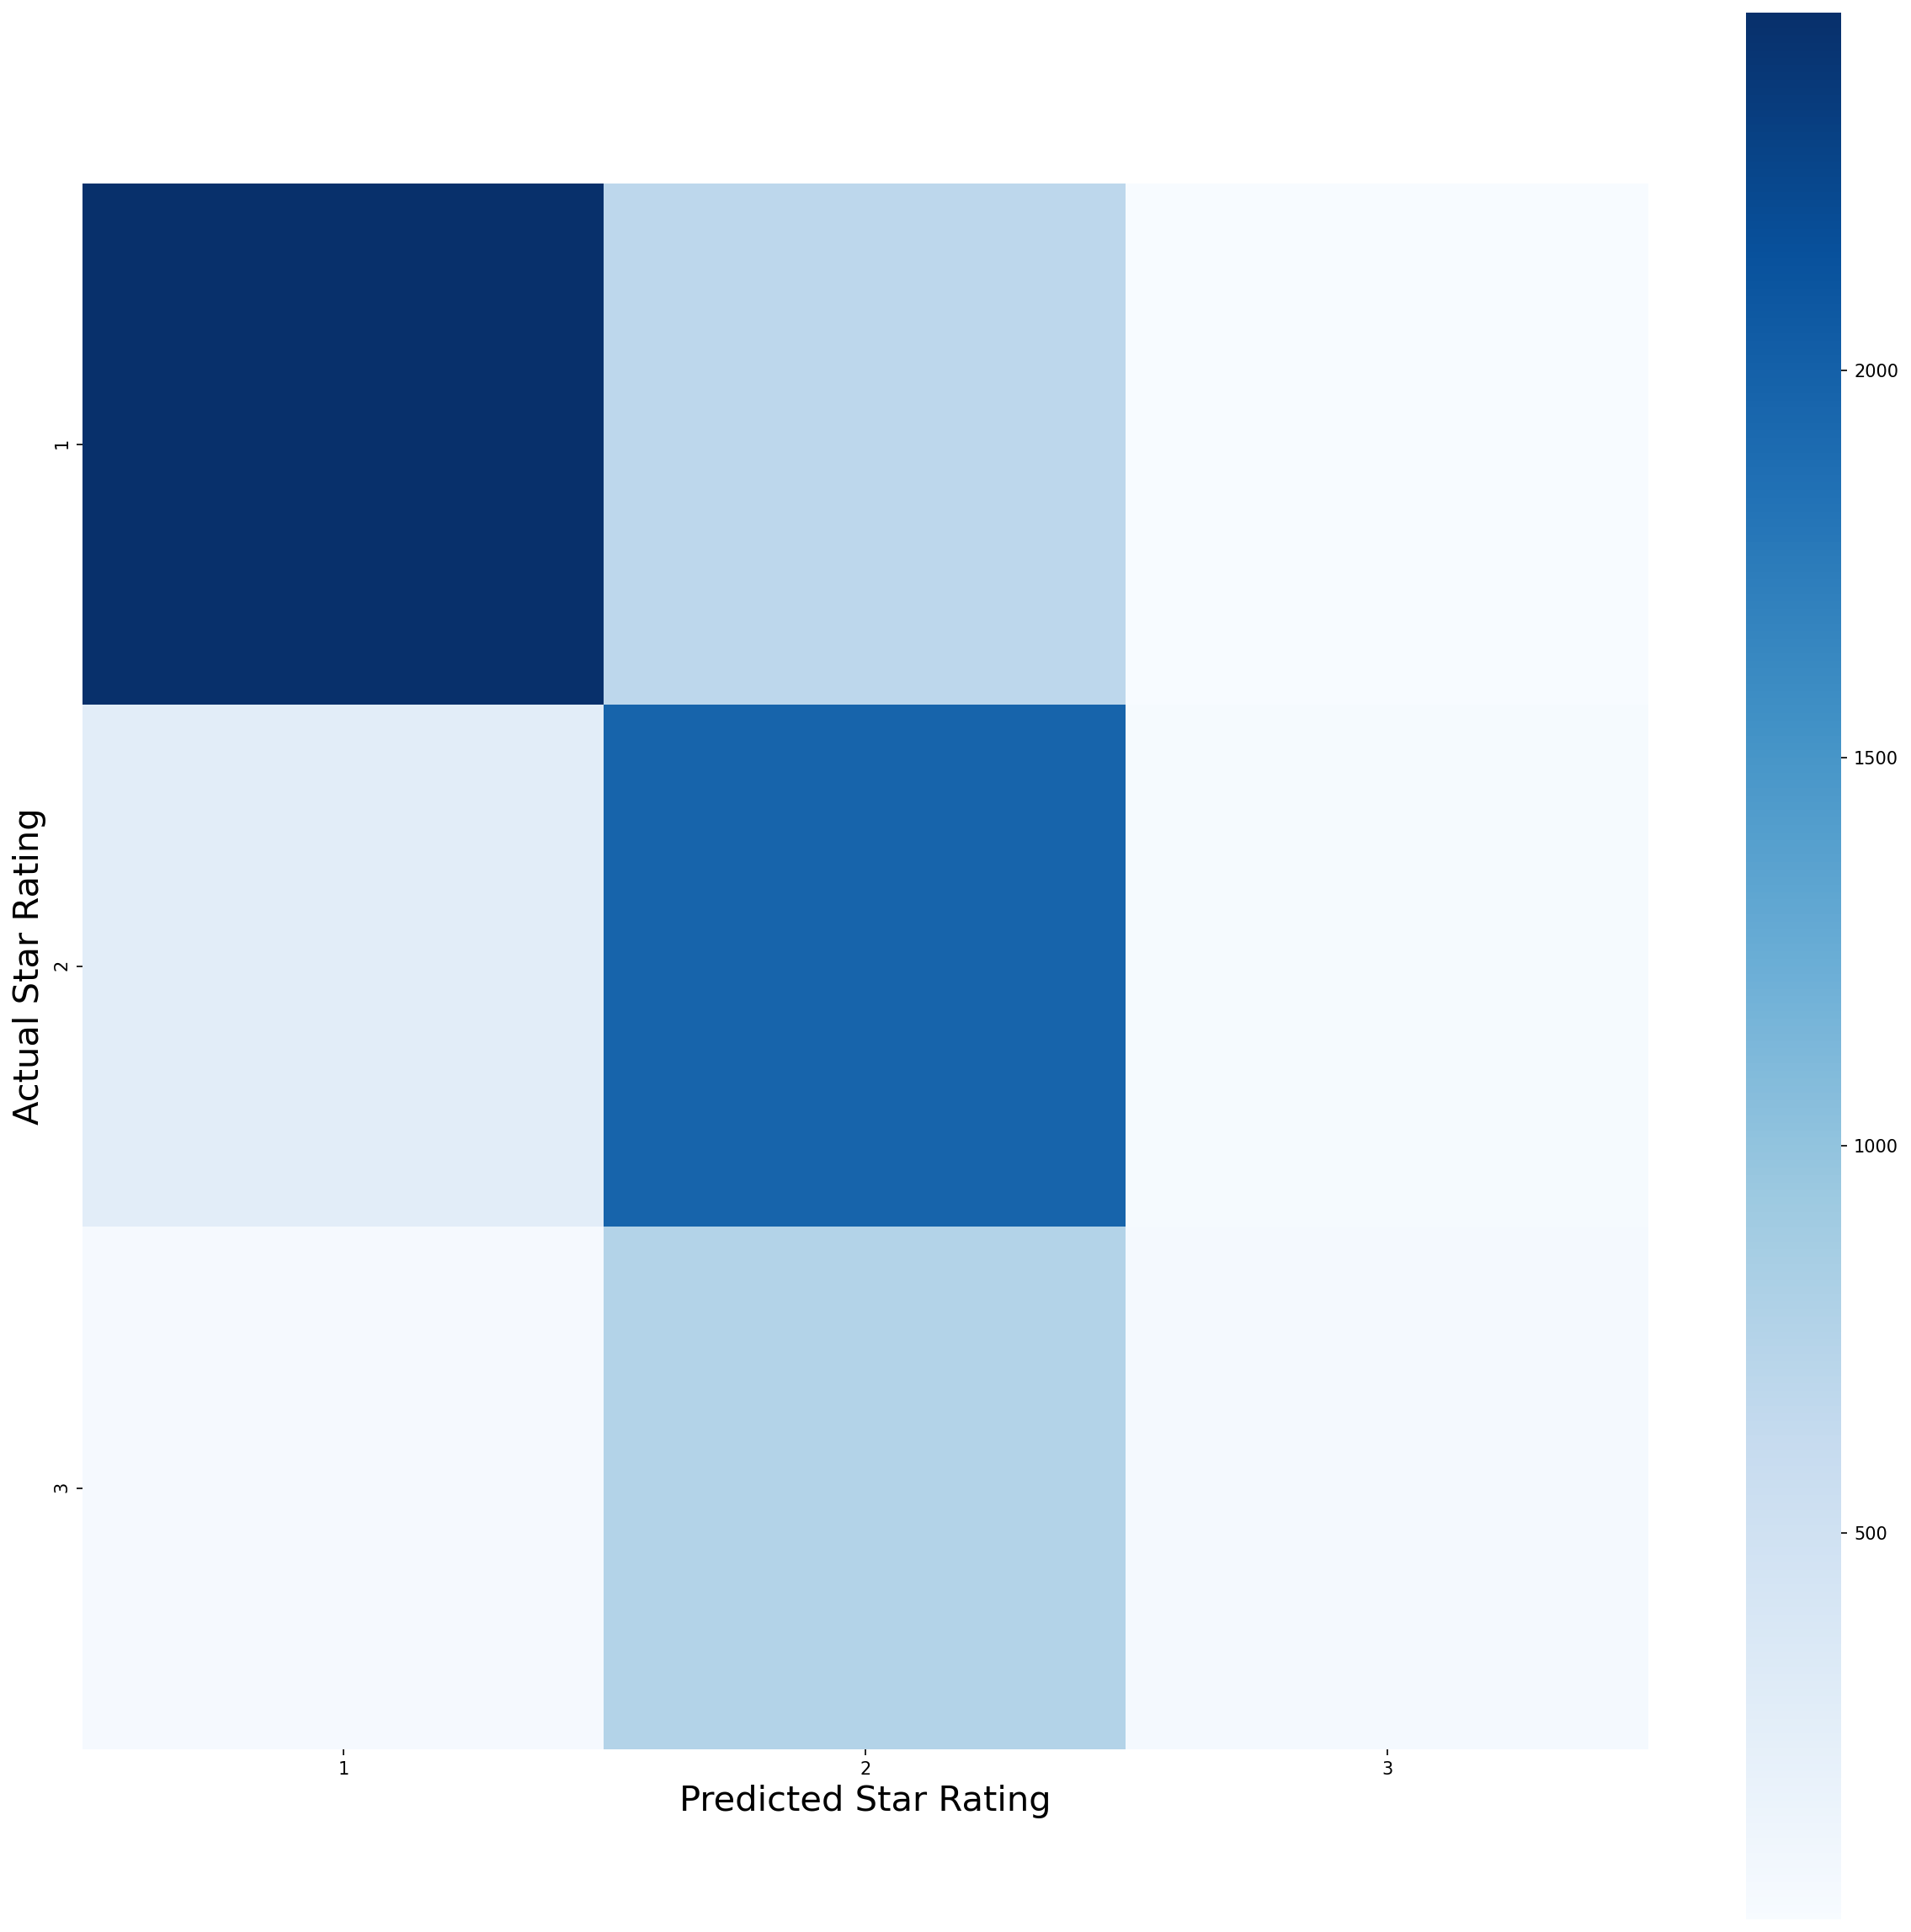

In [160]:
baseline_model2_confusion = confusion_matrix(y_test, y_pred_baseline2)
plt.figure(dpi=150,figsize=(20,20))
sns.heatmap(baseline_model2_confusion, cmap=plt.cm.Blues, square=True, 
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Star Rating", fontsize=20)
plt.ylabel("Actual Star Rating", fontsize=20)
plt.savefig("../Documents/Images/baseline2_confusion_matrix.png",dpi=400);

# Error Analysis
Find 3 predictions the CNN got right that the RF got wrong



    


In [191]:


#my_results = [<index in test_indices>, <correct_cnn_label>, <incorrect_rf_label>]
my_results = []
number_of_examples = 0

for idx,cnn_pred in enumerate(y_pred_baseline):
    
    if number_of_examples == 3:
        break
    
    if (cnn_pred == y_test[idx]) and (y_test[idx] != y_pred_rf[idx]):
        my_results.append([idx, cnn_pred,y_pred_rf[idx]])
        number_of_examples += 1


# Conclusion

In [192]:
my_results

[[6, 1, 0], [14, 1, 0], [16, 1, 0]]

In [193]:
example_indices = testing_indices[my_results[:][0]] 

In [194]:
example_indices

array([30453, 14232, 25613])

In [195]:
pd.options.display.max_colwidth = None

In [196]:
text_of_reviews.iloc[example_indices,:]

,review_title,review_text_original,review_star_rating,review_text,net_promoter_score
22504,Cronenberg now an 'auteur' of weirdness,"We used to expect gross-out horror from David Cronenberg. Now he gives us weird and weirder. MAPS TO THE STARS is set in a Tinseltown of designer homes, designer shops and exclusive restaurants. The background 'sheen' is reminiscent of an Almodovar movie, plus there's a Gothic element borrowed from Shyamalan (Agatha and Benjie see dead people). Julianne Moore's performance is in the kind of hyper-drive she brought to BOOGIE NIGHTS, which helps to power the movie's gearshift from Hollywood satire into violent melodrama. One of the themes is incest, which surely needed a deeper and subtler exploration.Robert Pattinson takes another step away from the Twilight Zone in the role of a limo driver with screen writing aspirations (like every other chauffeur in Los Angeles). Cronenberg is clearly reaching out towards a more discerning class of viewer. MAPS TO THE STARS is very much an 'auteur' movie, highly intelligent and stylized, but perhaps perched uncomfortably between satire and psychodrama.",6,now an of weirdness we use to expect horror from now he u weird and to the be set in a of designer designer and exclusive the background be reminiscent of an movie plus a element from and see dead people performance be in the kind of she bring to night which to power the gearshift from satire into violent melodrama one of the be incest which surely a and another step away from the twilight zone in the role of a driver with screen write like every other chauffeur in be clearly reach out towards a more discerning class of viewer to the be very much an movie highly intelligent and but perhaps uncomfortably between satire and psychodrama,1
52428,Fine for background watching,"Slumber is about a sleep doctor played by Maggie Q who tries to help a family cursed with sleepwalking nightmares, only to discover they're dealing with a problem modern medicine can't solve. This particular type of horror movie was kind of a thing in the late 2010s, possibly influenced by the very popular documentary about sleep paralysis that came out on a certain streaming channel. Maggie Q is wholly sympathetic as Dr. Alice Arnolds. She has a history of her own with bad dreams which is made crystal clear right from the beginning, so it's not a big frustrating reveal later in the movie (looking at you Nails). The movie has some really creepy set pieces and a good score, and most of the acting is perfect for the genre, especially the janitor's grandpa who shows up right in the middle to add some ham and cheese to the proceedings. However, sometimes the creepy set piece is allowed to go on for way too long, dragging all of the suspense out of it. I'm sure the director did not intend for the viewer to be complaining 'stab somebody already' at the screen. Also, some of the relationships seem to be arranged more for the convenience of the screenwriter and director than for the characters in the scene. It's convenient to the story to have the protagonist's daughter say some cryptic, then be told to leave and then go ahead and do so without throwing a tantrum, just as it is very convenient for the protagonist to have such a close relationship with the janitor at her work that not only does he take the trouble of announcing his resignation to her, he also hands her a warning note and when she needs to call on him for help, she knows exactly where he lives. This is all convenient, but so unrealistic it pulls the viewer right out of the story. Still, the movie is watchable enough to have on in the background while you are doing something else, and the ending is way more satisfying than similar movies with the same theme that came out right around the same time (looking at you Mara). Also worth mentioning: a cute animal comes to harm in this movie. If you hate it when the dog bites it, you might not want to queue this one up.",4,fine for background wa

In [204]:
#Fives where CNN got it right RF got it wrong
Rating = 0
number_of_examples = 5
current_numb = 0
my_results = []
for idx,cnn_pred in enumerate(y_pred_baseline):
    
    if current_numb == number_of_examples:
        break
    
    if (cnn_pred == y_test[idx]) and (y_test[idx] != y_pred_rf[idx]) and (y_test[idx] == Rating):
        my_results.append([idx, cnn_pred,y_pred_rf[idx]])
        current_numb += 1



In [205]:
my_results = np.array(my_results)

In [206]:
my_results

array([[ 48,   0,   1],
       [126,   0,   1],
       [159,   0,   1],
       [185,   0,   1],
       [190,   0,   1]])

In [207]:
my_results[:,0]

array([ 48, 126, 159, 185, 190])

In [208]:
example_indices = testing_indices[my_results[:,0]] 

In [209]:
example_indices

array([52656, 62392, 45713, 19275, 44516])

In [210]:
text_of_reviews.iloc[example_indices,:]

review_title  \
42484  Wildly offensive and disgusting piece of garbage   
40042                              Does Keanu ever age?   
61812                              Could've Been Better   
51061                           Could've used more work   
53832                        Track down a better script   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [ ]:
Rating = 9
number_of_examples = 5
current_numb = 0
my_results = []
for idx,cnn_pred in enumerate(y_pred_baseline):
    
    if current_numb == number_of_examples:
        break
    
    if (cnn_pred == y_test[idx]) and (y_test[idx] != y_pred_rf[idx]) and (y_test[idx] == Rating):
        my_results.append([idx, cnn_pred,y_pred_rf[idx]])
        current_numb += 1
my_results = np.array(my_results)
print(my_results)
example_indices = testing_indices[my_results[:,0]]

text_of_reviews.iloc[example_indices,:]

In [214]:
#examples of where CNN got it wrong
Rating = 2
number_of_examples = 3
current_numb = 0
my_results = []
for idx,cnn_pred in enumerate(y_pred_baseline):
    
    if current_numb == number_of_examples:
        break
    
    if (cnn_pred != y_test[idx]) and (y_test[idx] != y_pred_rf[idx]) and (y_test[idx] == Rating):
        my_results.append([idx, cnn_pred,y_test[idx]])
        current_numb += 1

my_results = np.array(my_results)
print(my_results)
example_indices = testing_indices[my_results[:,0]]

text_of_reviews.iloc[example_indices,:]

[[0 1 2]
 [8 1 2]
 [9 1 2]]


,review_title,review_text_original,review_star_rating,review_text,net_promoter_score
19655,The poetry of people and places,"Paterson is a celebration of the small details in life. A poetic and charming love-story about a perfectly ordinary couple, living in a perfectly ordinary town. The town in question is Paterson, New Jersey. Home of poet William Carlos Williams, comedian Lou Costello, and one of America's largest waterfalls. The man in question, in true Jarmusch style, is also named Paterson (played with pinpoint subtly by Adam Driver). Paterson is a hard-working bus driver who quietly goes about his duties, all the while allowing the scenery and eavesdropped conversation to inspire his main passion in life; writing poetry. Meanwhile, his girlfriend and the love of his life, played without fault by Iranian actress Golshifteh Farahani, is a stay-at-home creative. She spends her day baking imaginative cupcakes and making new curtains from scratch. The films narrative centres around a seven day week. Each day brings a new variation on the theme, and each moment a reflection on two people who wholeheartedly accept each other for who they are. Paterson is a quiet and contemplative film that sits perfectly in Jarmusch's repertoire. It's a film about how people choose to live their life, regardless of the necessities to work and make money. Like poetry, the words and images flow with little dramatic tension or conflict. Jarmusch explained at Cannes that he intended Paterson to be an antidote to the modern action film, and if this is the case, I'll definitely be coming back for another dose.",9,the poetry of people and be a celebration of the small in life a poetic and charm about a perfectly ordinary couple living in a perfectly ordinary town the town in question be new jersey home of poet comedian and one of the man in question in true style be also with pinpoint subtly by driver be a bus driver who quietly go about his all the while the scenery and conversation to inspire his main passion in life write poetry meanwhile his and the love of his life without fault by actress be a creative she her day bake imaginative and make new from scratch the narrative around a seven day week each day a new variation on the theme and each moment a reflection on two people who wholeheartedly accept each other for who they be be a quiet and contemplative film that perfectly in repertoire a film about how people choose to live their life regardless of the to work and make money like poetry the and flow with little dramatic tension or conflict at that he intend to be an antidote to the modern action film and if this be the case definitely be come back for another dose,2
61688,This film simply knocks out of the park,"This film simply knocks out of the park any films in the Christian genre. This movie offers the plausibility of happenings going on behind the scenes of accounts in the Bible, with budget worthy realism and good acting, that has made many Christians say... ""It's about time.""Like a good detective movie, we follow the main actors disbelief but openness to search for the truth. But what makes this movie stand out for me was the acting. The quality and intensity of the actors make this movie one that should not be missed. I recommend this movie to everyone.The emotional and interesting plot simply grabs you from the start and doesn't let go. In addition to a great written story, this film has a perfect mix of action and peaceful story telling, which doesn't make the movie drag on. You are constantly listening, paying attention, with action and fast paces scenes popping into the screen quickly. This movie simply makes the top 10 list of all the modern Christian movies made hands down. Totally recommend.",9,this film simply out of the park this film simply out of the park any in the genre this movie the plausibility of go on behind the of in the with budget worthy realism and good acting that make many say about a good detective movie we f

In [ ]:
Rating = 4
number_of_examples = 3
current_numb = 0
my_results = []
for idx,cnn_pred in enumerate(y_pred_baseline):
    
    if current_numb == number_of_examples:
        break
    
    if (cnn_pred != y_test[idx]) and (y_test[idx] != y_pred_rf[idx]) and (y_test[idx] == Rating):
        my_results.append([idx, cnn_pred,y_test[idx]])
        current_numb += 1

my_results = np.array(my_results)
print(my_results)
example_indices = testing_indices[my_results[:,0]]

text_of_reviews.iloc[example_indices,:]

In [ ]:
Rating = 1
number_of_examples = 3
current_numb = 0
my_results = []
for idx,cnn_pred in enumerate(y_pred_baseline):
    
    if current_numb == number_of_examples:
        break
    
    if (cnn_pred != y_test[idx]) and (y_test[idx] != y_pred_rf[idx]) and (y_test[idx] == Rating):
        my_results.append([idx, cnn_pred,y_test[idx]])
        current_numb += 1

my_results = np.array(my_results)
print(my_results)
example_indices = testing_indices[my_results[:,0]]

text_of_reviews.iloc[example_indices,:]